In [ ]:
%pip install transformers datasets
%pip install transformers
%pip install datasets
%pip install accelerate
%pip install easyocr
%pip install whisper
# Cài đặt OpenAI Whisper và thư viện hỗ trợ
%pip install -q git+https://github.com/openai/whisper.git

In [2]:
import os
import pandas as pd
import re
import time
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import AutoTokenizer, AutoProcessor, AutoModelForCTC, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import torch
from torch import nn
import librosa
import gradio as gr
import easyocr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import json, os

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import numpy as np
import random
import unicodedata
import re

# Load data
df = pd.read_csv('ViCTSD/ViCTSD_train.csv')

# --- Augmentation Helpers ---

def remove_accents(input_str):
    if not isinstance(input_str, str): return str(input_str)
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

teencode_dict = {
    r'\bkhông\b': 'k', r'\bkhong\b': 'k', r'\bko\b': 'k',
    r'\bđược\b': 'dc', r'\bduoc\b': 'dc',
    r'\bgì\b': 'j', r'\bgi\b': 'j',
    r'\bquá\b': 'qa', r'\bqua\b': 'qa',
    r'\bngười\b': 'ng', r'\bnguoi\b': 'ng',
    r'\bnhiều\b': 'nh', r'\bnhieu\b': 'nh',
    r'\bviệt nam\b': 'vn', r'\bviet nam\b': 'vn',
    r'\btại sao\b': 'ti shao',
    r'\bchồng\b': 'ck', r'\bvợ\b': 'vk',
    r'\bbuồn\b': 'buon',
    r'\bđang\b': 'dg',
    r'\bnhư\b': 'nhu',
    r'\bthôi\b': 'thoi',
    r'\bmày\b': 'm', r'\btao\b': 't', # adding some common aggressive pronouns often used in toxic speech
    r'\bchửi\b': 'chui',
}

def apply_teencode(text):
    if not isinstance(text, str): return ""
    new_text = text.lower()
    for pattern, replacement in teencode_dict.items():
        if random.random() < 0.5:
            new_text = re.sub(pattern, replacement, new_text)
    return new_text

def random_deletion(text, p=0.15):
    if not isinstance(text, str): return ""
    words = text.split()
    if len(words) <= 1: return text
    remaining = [w for w in words if random.random() > p]
    if len(remaining) == 0: return words[random.randint(0, len(words)-1)]
    return ' '.join(remaining)

def random_swap(text, n=1):
    if not isinstance(text, str): return ""
    words = text.split()
    length = len(words)
    if length < 2: return text
    for _ in range(n):
        idx1, idx2 = random.randint(0, length-1), random.randint(0, length-1)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def mix_comments(text1, text2):
    # Combine first half of text1 and second half of text2
    words1 = text1.split()
    words2 = text2.split()
    if not words1 or not words2: return text1

    mid1 = len(words1) // 2
    mid2 = len(words2) // 2

    new_words = words1[:mid1] + words2[mid2:]
    return ' '.join(new_words)

def augment_sentence(text, text_pair=None, type='general'):
    # text_pair is for mixing
    if type == 'toxic' and text_pair and random.random() < 0.3: # 30% chance to mix if toxic
        return mix_comments(text, text_pair)

    choice = random.choice(['accents', 'teencode', 'delete', 'swap', 'accents_teencode'])
    if choice == 'accents': return remove_accents(text)
    elif choice == 'teencode': return apply_teencode(text)
    elif choice == 'delete': return random_deletion(text)
    elif choice == 'swap': return random_swap(text)
    elif choice == 'accents_teencode': return apply_teencode(remove_accents(text))
    return text

# --- Main Logic ---

df_toxic = df[df['Toxicity'] == 1].reset_index(drop=True)
df_clean = df[df['Toxicity'] == 0].reset_index(drop=True)

# Target: Add 15k rows total. Let's aim for ~11k Toxic total and ~11k Clean total (22k total)
# Current: 759 Toxic, 6241 Clean
target_toxic_count = 11000
target_clean_count = 11000

new_rows = []

# Augment Toxic
# We need ~10250 new toxic rows
toxic_comments = df_toxic['Comment'].tolist()
current_toxic = 0
needed_toxic = target_toxic_count - len(df_toxic)

while current_toxic < needed_toxic:
    # Pick random source
    idx = random.randint(0, len(df_toxic)-1)
    src_row = df_toxic.iloc[idx]
    text = src_row['Comment']

    # Pick a pair for potential mixing
    idx2 = random.randint(0, len(df_toxic)-1)
    text2 = df_toxic.iloc[idx2]['Comment']

    new_text = augment_sentence(text, text2, type='toxic')

    # Simple dedup
    if new_text != text:
        row = src_row.copy()
        row['Comment'] = new_text
        new_rows.append(row)
        current_toxic += 1

# Augment Clean
# We need ~4760 new clean rows
needed_clean = target_clean_count - len(df_clean)
clean_comments = df_clean['Comment'].tolist()
current_clean = 0

while current_clean < needed_clean:
    idx = random.randint(0, len(df_clean)-1)
    src_row = df_clean.iloc[idx]
    text = src_row['Comment']

    new_text = augment_sentence(text, type='clean')

    if new_text != text:
        row = src_row.copy()
        row['Comment'] = new_text
        new_rows.append(row)
        current_clean += 1

# Combine
df_new = pd.DataFrame(new_rows)
df_combined = pd.concat([df, df_new], ignore_index=True)

# Shuffle thoroughly
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Cleanup
if 'Unnamed: 0' in df_combined.columns:
    df_combined.drop(columns=['Unnamed: 0'], inplace=True)

print("Final Shape:", df_combined.shape)
print(df_combined['Toxicity'].value_counts())
df_combined.to_csv('ViCTSD_augmented_final.csv', index=False)

Final Shape: (22000, 5)
Toxicity
1    11000
0    11000
Name: count, dtype: int64


In [7]:
# ĐƯỜNG DẪN ĐẾN THƯ MỤC CHỨA 3 FILE CSV
base_dir = 'ViCTSD'

# Tên các file
train_file = 'ViCTSD_augmented_final.csv'
valid_file = 'ViCTSD_valid.csv'
test_file = 'ViCTSD_test.csv'

PHOBERT_MODEL = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(PHOBERT_MODEL)
print(f"✅ PhoBERT Tokenizer ({PHOBERT_MODEL}) đã được tải.")

# ĐỊNH NGHĨA HÀM TIỀN XỬ LÝ VÀ TOKEN HÓA
def basic_cleanup(text):
    """Làm sạch cơ bản (thay thế Tách từ VnCoreNLP)."""
    text = str(text)
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_tokenize_data_direct(filename, base_dir, tokenizer):
    """Đọc file, làm sạch và Token hóa trực tiếp."""
    file_path = os.path.join(base_dir, filename)
    print(f"\n--- Xử lý file: {filename} ---")

    if not os.path.exists(file_path):
        print(f"❌ LỖI: Không tìm thấy file tại {file_path}. Bỏ qua.")
        return None

    df = pd.read_csv(file_path)
    df_clean = df[['Comment', 'Toxicity']].copy()
    df_clean.rename(columns={'Comment': 'text', 'Toxicity': 'label'}, inplace=True)

    # Làm sạch văn bản
    df_clean['text'] = df_clean['text'].apply(basic_cleanup)

    # Chuyển đổi sang HuggingFace Dataset
    dataset = Dataset.from_pandas(df_clean[['text', 'label']])

    # Áp dụng Tokenization TRỰC TIẾP
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"]) # Xóa cột văn bản thô

    print(f"✅ Hoàn thành. Kích thước dataset: {len(tokenized_dataset)}")
    return tokenized_dataset

# 4. THỰC HIỆN TẢI VÀ TOKEN HÓA
train_tokenized = load_and_tokenize_data_direct(train_file, base_dir, tokenizer)
val_tokenized = load_and_tokenize_data_direct(valid_file, base_dir, tokenizer)
test_tokenized = load_and_tokenize_data_direct(test_file, base_dir, tokenizer)

✅ PhoBERT Tokenizer (vinai/phobert-base) đã được tải.

--- Xử lý file: ViCTSD_augmented_final.csv ---


Map: 100%|██████████| 22000/22000 [00:03<00:00, 7064.17 examples/s]


✅ Hoàn thành. Kích thước dataset: 22000

--- Xử lý file: ViCTSD_valid.csv ---


Map: 100%|██████████| 2000/2000 [00:00<00:00, 6432.15 examples/s]


✅ Hoàn thành. Kích thước dataset: 2000

--- Xử lý file: ViCTSD_test.csv ---


Map: 100%|██████████| 1000/1000 [00:00<00:00, 6580.72 examples/s]

✅ Hoàn thành. Kích thước dataset: 1000


In [8]:
# --- HÀM TÔ MÀU VÀ DANH SÁCH TỪ ĐỘC HẠI ---
# Danh sách mẫu: Cần được mở rộng dựa trên phân tích dữ liệu ViCTSD
TOXIC_WORDS = set([
    'ngu dốt', 'cút', 'chó', 'điên', 'óc chó', 'rác rưởi', 'khùng',
    'mày', 'tao', 'đồ ngu', 'mất dạy', 'chết đi', 'thằng', 'con'
])

def highlight_toxic_words(text):
    """Tô màu đỏ các từ/cụm từ độc hại trong văn bản và trả về chuỗi HTML."""
    if not text:
        return ""

    highlighted_text = text

    # Sắp xếp từ độc hại theo độ dài giảm dần để cụm từ dài được ưu tiên
    sorted_words = sorted(list(TOXIC_WORDS), key=len, reverse=True)

    for word in sorted_words:
        # Dùng re.escape để xử lý các ký tự đặc biệt trong từ độc hại
        # Dùng r'\b(' + word + r')\b' để đảm bảo tìm thấy toàn bộ từ (word boundaries)
        pattern = r'\b(' + re.escape(word) + r')\b'

        # Tô màu đỏ đậm bằng thẻ HTML
        highlighted_text = re.sub(
            pattern,
            r'<span style="color:red; font-weight:bold;">\1</span>',
            highlighted_text,
            flags=re.IGNORECASE
        )

    return highlighted_text

# --- HÀM OCR VÀ PHÂN LOẠI HÌNH ẢNH ---
def ocr_and_predict(image_file, tokenizer, model, reader):
    """Thực hiện OCR trên ảnh và phân loại văn bản trích xuất."""
    ocr_text = ""
    is_toxic = 0
    confidence = 0.5

    if image_file is not None and reader is not None:
        try:
            # 1. Thực hiện OCR
            results = reader.readtext(image_file)

            # 2. Nối tất cả văn bản trích xuất thành một chuỗi
            if results:
                # res[1] là văn bản trích xuất
                ocr_text = " ".join([res[1] for res in results])

            # 3. Phân loại HSD
            if ocr_text:
                # classify_text_toxicity cần được định nghĩa trước
                is_toxic, confidence = classify_text_toxicity(ocr_text, tokenizer, model)

        except Exception as e:
            ocr_text = f"❌ LỖI OCR: {e}"
            is_toxic = 0
            confidence = 0.5

    return ocr_text, is_toxic, confidence

# Thực nghiệm baseline model

Train shape: (22000, 5)
Test shape: (1000, 6)
Valid shape: (2000, 6)

Columns: ['Comment', 'Constructiveness', 'Toxicity', 'Title', 'Topic']

Label distribution (train):
 0    11000
1    11000
Name: count, dtype: int64

Label distribution (test):
 0    890
1    110
Name: count, dtype: int64

Label distribution (valid):
 Toxicity
0    1768
1     232
Name: count, dtype: int64


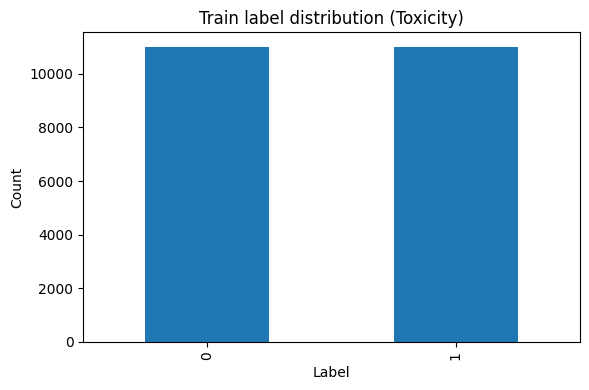


Fitting TF-IDF on train...
TF-IDF shapes: (22000, 10000) (1000, 10000)

Training MultinomialNB...
NB Accuracy: 0.8710 | Time: 0.01s
              precision    recall  f1-score   support

           0     0.9299    0.9247    0.9273       890
           1     0.4174    0.4364    0.4267       110

    accuracy                         0.8710      1000
   macro avg     0.6737    0.6805    0.6770      1000
weighted avg     0.8736    0.8710    0.8723      1000


Training LogisticRegression...
LR Accuracy: 0.8490 | Time: 0.27s
              precision    recall  f1-score   support

           0     0.9457    0.8809    0.9122       890
           1     0.3801    0.5909    0.4626       110

    accuracy                         0.8490      1000
   macro avg     0.6629    0.7359    0.6874      1000
weighted avg     0.8835    0.8490    0.8627      1000


Training LinearSVC (faster for sparse data)...
SVM Accuracy: 0.8520 | Time: 0.45s
              precision    recall  f1-score   support

         

In [10]:
# Paths (as in earlier)
train_path = 'ViCTSD/ViCTSD_augmented_final.csv'
test_path = 'ViCTSD/ViCTSD_test.csv'
valid_path = 'ViCTSD/ViCTSD_valid.csv'
nbest_report = {}

# Load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
valid = pd.read_csv(valid_path)

# Basic checks
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Valid shape:", valid.shape)
print("\nColumns:", train.columns.tolist())

# Ensure Comment and Toxicity exist
for df,name in [(train,'train'),(test,'test'),(valid,'valid')]:
    if 'Comment' not in df.columns or 'Toxicity' not in df.columns:
        raise ValueError(f"Missing required columns in {name}")

# Prepare data (use train/test for baseline)
X_train_text = train['Comment'].astype(str).fillna("")
y_train = train['Toxicity'].astype(int).tolist()
X_test_text = test['Comment'].astype(str).fillna("")
y_test = test['Toxicity'].astype(int).tolist()

# Check label distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()
valid_counts = pd.Series(valid['Toxicity'].astype(int)).value_counts().sort_index()

print("\nLabel distribution (train):\n", train_counts)
print("\nLabel distribution (test):\n", test_counts)
print("\nLabel distribution (valid):\n", valid_counts)

# Plot train distribution
plt.figure(figsize=(6,4))
train_counts.plot(kind='bar')
plt.title("Train label distribution (Toxicity)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
print("\nFitting TF-IDF on train...")
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

results = []

# Naive Bayes
print("\nTraining MultinomialNB...")
start = time.time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)
nb_time = time.time() - start
nb_acc = accuracy_score(y_test, nb_pred)
print(f"NB Accuracy: {nb_acc:.4f} | Time: {nb_time:.2f}s")
print(classification_report(y_test, nb_pred, digits=4))
results.append({"Model":"MultinomialNB","Accuracy":nb_acc,"Time":nb_time})

# Logistic Regression
print("\nTraining LogisticRegression...")
start = time.time()
lr = LogisticRegression(max_iter=1000, solver='saga')
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_time = time.time() - start
lr_acc = accuracy_score(y_test, lr_pred)
print(f"LR Accuracy: {lr_acc:.4f} | Time: {lr_time:.2f}s")
print(classification_report(y_test, lr_pred, digits=4))
results.append({"Model":"LogisticRegression","Accuracy":lr_acc,"Time":lr_time})

# SVM (linear) - use a linear SVC via LinearSVC for speed, but keep SVC if needed.
from sklearn.svm import LinearSVC
print("\nTraining LinearSVC (faster for sparse data)...")
start = time.time()
svm = LinearSVC(max_iter=5000)
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)
svm_time = time.time() - start
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_acc:.4f} | Time: {svm_time:.2f}s")
print(classification_report(y_test, svm_pred, digits=4))
results.append({"Model":"LinearSVC","Accuracy":svm_acc,"Time":svm_time})

# Summary
res_df = pd.DataFrame(results)
print("\nSummary:\n", res_df)

In [11]:
%pip install --upgrade transformers accelerate

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/6a/6b/2f416568b3c4c91c96e5a365d164f8a4a4a88030aa8ab4644181fdadce97/transformers-4.57.3-py3-none-any.whl.metadata
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.34.0 from https://files.pythonhosted.org/packages/cb/bd/1a875e0d592d447cbc02805fd3fe0f497714d6a2583f59d14fa9ebad96eb/huggingface_hub-0.36.0-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Obtaining dependency information for tokenizers<=0.23.0,>=0.22.0 from https://files.pythonhosted.org/packages/b3/46/e33a8c93907b631a99377ef4c5f817ab453d0b34f93529421f42ff559671/tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (5

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\~okenizers\\tokenizers.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# ===================================================================
# SECTION PHOBERT (HUẤN LUYỆN MÔ HÌNH VĂN BẢN)
#
# Mục tiêu: Huấn luyện PhoBERT trên 3 file CSV để phân loại
# văn bản độc hại, có xử lý mất cân bằng dữ liệu (weighted loss).
# ===================================================================

# --- 0. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import torch
from torch import nn

# --- KIỂM TRA ĐIỀU KIỆN TIÊN QUYẾT ---
# Đảm bảo 'train_tokenized' (từ ô code Tải dữ liệu) đã được tạo
try:
    if 'train_tokenized' not in locals() or 'val_tokenized' not in locals() or 'tokenizer' not in locals():
        print("❌ LỖI: Biến 'train_tokenized', 'val_tokenized', hoặc 'tokenizer' không tồn tại.")
        print("Vui lòng chạy lại ô code TẢI DỮ LIỆU (Data Loading) ở trên trước.")
        raise NameError("Dữ liệu chưa được tải")
except NameError as e:
    # Dừng thực thi nếu thiếu dữ liệu
    raise e

# --- 1. TÍNH TOÁN TRỌNG SỐ LỚP ---
print("\n--- 1. Bắt đầu tính toán trọng số lớp ---")
# Đảm bảo sử dụng GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

# Tải nhãn từ tập huấn luyện để tính toán trọng số
train_labels = np.array(train_tokenized['label'])
num_clean = np.sum(train_labels == 0) # Số lượng mẫu Sạch (0)
num_toxic = np.sum(train_labels == 1) # Số lượng mẫu Độc hại (1)
total_samples = len(train_labels)

# Tính trọng số nghịch đảo (Inverse Frequency)
# Công thức: Tổng mẫu / (2 * Số mẫu của lớp đó)
weight_0 = total_samples / (2.0 * num_clean)
weight_1 = total_samples / (2.0 * num_toxic)

# Chuyển trọng số thành Tensor và đưa lên GPU
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)
print(f"Tổng mẫu Train: {total_samples}. Sạch: {num_clean}, Độc hại: {num_toxic}")
print(f"Trọng số lớp đã tính: Sạch (0) = {weight_0:.4f}, Độc hại (1) = {weight_1:.4f}")

# --- 2. ĐỊNH NGHĨA MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---
print("\n--- 2. Định nghĩa mô hình PhoBERT có trọng số ---")
PHOBERT_MODEL = "vinai/phobert-base"

class PhoBERT_Weighted(AutoModelForSequenceClassification):
    """Mô hình kế thừa để sử dụng Cross-Entropy Loss có trọng số."""
    def __init__(self, config):
        super().__init__(config)
        # Định nghĩa hàm mất mát (CrossEntropyLoss) với trọng số TÍNH ĐƯỢC
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, labels=None, **kwargs):
        # Chạy forward pass gốc của mô hình
        outputs = super().forward(input_ids=input_ids, labels=labels, **kwargs)

        if labels is None:
            return outputs

        # Tính toán lại loss bằng hàm mất mát có trọng số
        logits = outputs.logits
        # Đảm bảo labels có kiểu long (int64)
        loss = self.loss_fct(logits, labels.long())

        outputs.loss = loss
        return outputs

# Tải mô hình PhoBERT mới, sử dụng lớp Weighted
model_weighted = PhoBERT_Weighted.from_pretrained(PHOBERT_MODEL, num_labels=2).to(device)
print(f"✅ Tải thành công mô hình {PHOBERT_MODEL} với hàm loss tùy chỉnh.")

# --- 3. ĐỊNH NGHĨA HÀM ĐÁNH GIÁ VÀ THAM SỐ HUẤN LUYỆN ---
print("\n--- 3. Định nghĩa hàm đánh giá và tham số huấn luyện ---")

# Định nghĩa hàm đánh giá hiệu suất (compute_metrics)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
    }

# Định nghĩa Tham số Huấn luyện
training_args = TrainingArguments(
    output_dir="./phobert_toxic_weighted_results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./phobert_toxic_weighted_logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True if device.type == 'cuda' else False,
    report_to="none"
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model_weighted, # SỬ DỤNG MODEL MỚI CÓ TRỌNG SỐ
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer, # Sử dụng tokenizer đã tải từ các bước trước
    compute_metrics=compute_metrics,
)

# --- 4. BẮT ĐẦU HUẤN LUYỆN ---
print("\n--- 4. BẮT ĐẦU TÁI HUẤN LUYỆN MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---")
trainer.train()

# --- 5. LƯU MÔ HÌNH ---
print("\n--- 5. Lưu mô hình tốt nhất ---")
# Lưu mô hình cuối cùng (tốt nhất)
trainer.save_model("./phobert_toxic_weighted_final_model")
tokenizer.save_pretrained("./phobert_toxic_weighted_final_model")

print("\n--- TÁI HUẤN LUYỆN HOÀN TẤT ---")
print("✅ Mô hình đã được lưu vào thư mục: ./phobert_toxic_weighted_final_model")


--- 1. Bắt đầu tính toán trọng số lớp ---
Thiết bị sử dụng: cuda
Tổng mẫu Train: 22000. Sạch: 11000, Độc hại: 11000
Trọng số lớp đã tính: Sạch (0) = 1.0000, Độc hại (1) = 1.0000

--- 2. Định nghĩa mô hình PhoBERT có trọng số ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Tải thành công mô hình vinai/phobert-base với hàm loss tùy chỉnh.

--- 3. Định nghĩa hàm đánh giá và tham số huấn luyện ---

--- 4. BẮT ĐẦU TÁI HUẤN LUYỆN MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_17912\2031399505.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  1%|          | 101/13750 [00:21<47:25,  4.80it/s]

{'loss': 0.6852, 'grad_norm': 3.072145700454712, 'learning_rate': 9.800000000000001e-06, 'epoch': 0.07}


  1%|▏         | 201/13750 [00:42<46:56,  4.81it/s]

{'loss': 0.628, 'grad_norm': 20.256208419799805, 'learning_rate': 1.9800000000000004e-05, 'epoch': 0.15}


  2%|▏         | 301/13750 [01:02<46:44,  4.80it/s]

{'loss': 0.5644, 'grad_norm': 7.538612365722656, 'learning_rate': 2.96e-05, 'epoch': 0.22}


  3%|▎         | 401/13750 [01:23<46:20,  4.80it/s]

{'loss': 0.527, 'grad_norm': 11.723662376403809, 'learning_rate': 3.960000000000001e-05, 'epoch': 0.29}


  4%|▎         | 501/13750 [01:44<46:15,  4.77it/s]

{'loss': 0.5012, 'grad_norm': 9.432171821594238, 'learning_rate': 4.96e-05, 'epoch': 0.36}


  4%|▍         | 601/13750 [02:05<45:45,  4.79it/s]

{'loss': 0.4706, 'grad_norm': 59.9413948059082, 'learning_rate': 4.963773584905661e-05, 'epoch': 0.44}


  5%|▌         | 701/13750 [02:26<45:34,  4.77it/s]

{'loss': 0.4448, 'grad_norm': 6.189495086669922, 'learning_rate': 4.9260377358490565e-05, 'epoch': 0.51}


  6%|▌         | 801/13750 [02:47<44:55,  4.80it/s]

{'loss': 0.3983, 'grad_norm': 10.8284273147583, 'learning_rate': 4.888301886792453e-05, 'epoch': 0.58}


  7%|▋         | 901/13750 [03:08<45:02,  4.75it/s]

{'loss': 0.373, 'grad_norm': 3.9314682483673096, 'learning_rate': 4.850566037735849e-05, 'epoch': 0.65}


  7%|▋         | 1001/13750 [03:29<44:38,  4.76it/s]

{'loss': 0.3652, 'grad_norm': 15.589850425720215, 'learning_rate': 4.812830188679245e-05, 'epoch': 0.73}


  8%|▊         | 1101/13750 [03:50<44:29,  4.74it/s]

{'loss': 0.2942, 'grad_norm': 14.999109268188477, 'learning_rate': 4.7750943396226415e-05, 'epoch': 0.8}


  9%|▊         | 1201/13750 [04:11<44:01,  4.75it/s]

{'loss': 0.3076, 'grad_norm': 25.791269302368164, 'learning_rate': 4.737358490566038e-05, 'epoch': 0.87}


  9%|▉         | 1301/13750 [04:32<43:36,  4.76it/s]

{'loss': 0.3021, 'grad_norm': 21.276575088500977, 'learning_rate': 4.6996226415094344e-05, 'epoch': 0.95}


                                                    
 10%|█         | 1375/13750 [04:53<43:10,  4.78it/s]

{'eval_loss': 0.36732399463653564, 'eval_accuracy': 0.8395, 'eval_f1_score': 0.4830917874396135, 'eval_precision': 0.3856041131105398, 'eval_recall': 0.646551724137931, 'eval_runtime': 5.6849, 'eval_samples_per_second': 351.808, 'eval_steps_per_second': 21.988, 'epoch': 1.0}


 10%|█         | 1401/13750 [05:00<43:18,  4.75it/s]  

{'loss': 0.2761, 'grad_norm': 45.132789611816406, 'learning_rate': 4.66188679245283e-05, 'epoch': 1.02}


 11%|█         | 1501/13750 [05:21<42:55,  4.76it/s]

{'loss': 0.2687, 'grad_norm': 33.802886962890625, 'learning_rate': 4.6241509433962266e-05, 'epoch': 1.09}


 12%|█▏        | 1601/13750 [05:42<43:04,  4.70it/s]

{'loss': 0.2187, 'grad_norm': 15.508271217346191, 'learning_rate': 4.586415094339623e-05, 'epoch': 1.16}


 12%|█▏        | 1701/13750 [06:04<42:57,  4.68it/s]

{'loss': 0.2198, 'grad_norm': 59.808345794677734, 'learning_rate': 4.548679245283019e-05, 'epoch': 1.24}


 13%|█▎        | 1801/13750 [06:25<42:18,  4.71it/s]

{'loss': 0.2267, 'grad_norm': 11.687610626220703, 'learning_rate': 4.510943396226415e-05, 'epoch': 1.31}


 14%|█▍        | 1901/13750 [06:46<42:06,  4.69it/s]

{'loss': 0.1849, 'grad_norm': 26.83234977722168, 'learning_rate': 4.4732075471698116e-05, 'epoch': 1.38}


 15%|█▍        | 2001/13750 [07:07<41:29,  4.72it/s]

{'loss': 0.176, 'grad_norm': 0.6351841688156128, 'learning_rate': 4.4354716981132074e-05, 'epoch': 1.45}


 15%|█▌        | 2101/13750 [07:29<41:18,  4.70it/s]

{'loss': 0.1811, 'grad_norm': 48.94866943359375, 'learning_rate': 4.397735849056604e-05, 'epoch': 1.53}


 16%|█▌        | 2201/13750 [07:50<40:58,  4.70it/s]

{'loss': 0.2157, 'grad_norm': 9.29702377319336, 'learning_rate': 4.36e-05, 'epoch': 1.6}


 17%|█▋        | 2301/13750 [08:11<40:46,  4.68it/s]

{'loss': 0.2162, 'grad_norm': 23.527389526367188, 'learning_rate': 4.322264150943397e-05, 'epoch': 1.67}


 17%|█▋        | 2401/13750 [08:32<40:07,  4.71it/s]

{'loss': 0.1605, 'grad_norm': 58.493560791015625, 'learning_rate': 4.2845283018867925e-05, 'epoch': 1.75}


 18%|█▊        | 2501/13750 [08:54<39:50,  4.71it/s]

{'loss': 0.1916, 'grad_norm': 21.58202362060547, 'learning_rate': 4.247169811320755e-05, 'epoch': 1.82}


 19%|█▉        | 2601/13750 [09:15<39:52,  4.66it/s]

{'loss': 0.2061, 'grad_norm': 7.79996919631958, 'learning_rate': 4.2094339622641507e-05, 'epoch': 1.89}


 20%|█▉        | 2701/13750 [09:37<39:41,  4.64it/s]

{'loss': 0.1898, 'grad_norm': 5.076202869415283, 'learning_rate': 4.171698113207547e-05, 'epoch': 1.96}


                                                    
 20%|██        | 2750/13750 [09:53<39:14,  4.67it/s]

{'eval_loss': 0.523281991481781, 'eval_accuracy': 0.893, 'eval_f1_score': 0.4880382775119617, 'eval_precision': 0.5483870967741935, 'eval_recall': 0.4396551724137931, 'eval_runtime': 5.752, 'eval_samples_per_second': 347.707, 'eval_steps_per_second': 21.732, 'epoch': 2.0}


 20%|██        | 2801/13750 [10:06<39:13,  4.65it/s]  

{'loss': 0.1124, 'grad_norm': 3.7612226009368896, 'learning_rate': 4.1339622641509435e-05, 'epoch': 2.04}


 21%|██        | 2901/13750 [10:27<38:40,  4.67it/s]

{'loss': 0.1085, 'grad_norm': 0.22448298335075378, 'learning_rate': 4.09622641509434e-05, 'epoch': 2.11}


 22%|██▏       | 3001/13750 [10:49<38:33,  4.65it/s]

{'loss': 0.1616, 'grad_norm': 0.0823759138584137, 'learning_rate': 4.058490566037736e-05, 'epoch': 2.18}


 23%|██▎       | 3101/13750 [11:10<37:48,  4.69it/s]

{'loss': 0.1194, 'grad_norm': 24.33922576904297, 'learning_rate': 4.020754716981132e-05, 'epoch': 2.25}


 23%|██▎       | 3201/13750 [11:32<37:47,  4.65it/s]

{'loss': 0.101, 'grad_norm': 4.351962089538574, 'learning_rate': 3.9830188679245286e-05, 'epoch': 2.33}


 24%|██▍       | 3301/13750 [11:53<37:06,  4.69it/s]

{'loss': 0.1129, 'grad_norm': 0.3366621136665344, 'learning_rate': 3.9452830188679243e-05, 'epoch': 2.4}


 25%|██▍       | 3401/13750 [12:14<36:51,  4.68it/s]

{'loss': 0.0983, 'grad_norm': 0.14518265426158905, 'learning_rate': 3.907547169811321e-05, 'epoch': 2.47}


 25%|██▌       | 3501/13750 [12:36<37:00,  4.62it/s]

{'loss': 0.1525, 'grad_norm': 46.77155303955078, 'learning_rate': 3.869811320754717e-05, 'epoch': 2.55}


 26%|██▌       | 3601/13750 [12:57<37:10,  4.55it/s]

{'loss': 0.1279, 'grad_norm': 61.948219299316406, 'learning_rate': 3.8320754716981136e-05, 'epoch': 2.62}


 27%|██▋       | 3701/13750 [13:19<37:29,  4.47it/s]

{'loss': 0.105, 'grad_norm': 66.35035705566406, 'learning_rate': 3.7943396226415094e-05, 'epoch': 2.69}


 28%|██▊       | 3801/13750 [13:41<34:59,  4.74it/s]

{'loss': 0.1094, 'grad_norm': 1.0510568618774414, 'learning_rate': 3.756603773584906e-05, 'epoch': 2.76}


 28%|██▊       | 3901/13750 [14:02<34:45,  4.72it/s]

{'loss': 0.1337, 'grad_norm': 1.2641465663909912, 'learning_rate': 3.718867924528302e-05, 'epoch': 2.84}


 29%|██▉       | 4001/13750 [14:23<34:39,  4.69it/s]

{'loss': 0.0782, 'grad_norm': 0.0792427733540535, 'learning_rate': 3.681132075471698e-05, 'epoch': 2.91}


 30%|██▉       | 4101/13750 [14:45<34:02,  4.72it/s]

{'loss': 0.0866, 'grad_norm': 0.015686888247728348, 'learning_rate': 3.6433962264150945e-05, 'epoch': 2.98}


                                                    
 30%|███       | 4125/13750 [14:55<34:02,  4.71it/s]

{'eval_loss': 0.7736368179321289, 'eval_accuracy': 0.887, 'eval_f1_score': 0.4263959390862944, 'eval_precision': 0.5185185185185185, 'eval_recall': 0.3620689655172414, 'eval_runtime': 5.7359, 'eval_samples_per_second': 348.679, 'eval_steps_per_second': 21.792, 'epoch': 3.0}


 31%|███       | 4201/13750 [15:15<34:15,  4.65it/s]  

{'loss': 0.0636, 'grad_norm': 0.1546141505241394, 'learning_rate': 3.605660377358491e-05, 'epoch': 3.05}


 31%|███▏      | 4301/13750 [15:36<33:36,  4.69it/s]

{'loss': 0.0517, 'grad_norm': 0.015456123277544975, 'learning_rate': 3.5679245283018867e-05, 'epoch': 3.13}


 32%|███▏      | 4401/13750 [15:57<33:06,  4.71it/s]

{'loss': 0.0903, 'grad_norm': 20.073932647705078, 'learning_rate': 3.530188679245283e-05, 'epoch': 3.2}


 33%|███▎      | 4501/13750 [16:18<32:34,  4.73it/s]

{'loss': 0.088, 'grad_norm': 61.01039123535156, 'learning_rate': 3.4924528301886795e-05, 'epoch': 3.27}


 33%|███▎      | 4601/13750 [16:39<32:28,  4.70it/s]

{'loss': 0.0692, 'grad_norm': 0.021078510209918022, 'learning_rate': 3.454716981132076e-05, 'epoch': 3.35}


 34%|███▍      | 4701/13750 [17:01<32:03,  4.70it/s]

{'loss': 0.0697, 'grad_norm': 0.023049093782901764, 'learning_rate': 3.416981132075472e-05, 'epoch': 3.42}


 35%|███▍      | 4801/13750 [17:22<31:53,  4.68it/s]

{'loss': 0.0907, 'grad_norm': 0.034762509167194366, 'learning_rate': 3.379245283018868e-05, 'epoch': 3.49}


 36%|███▌      | 4901/13750 [17:43<31:17,  4.71it/s]

{'loss': 0.0733, 'grad_norm': 1.2843387126922607, 'learning_rate': 3.3415094339622646e-05, 'epoch': 3.56}


 36%|███▋      | 5001/13750 [18:04<30:54,  4.72it/s]

{'loss': 0.0472, 'grad_norm': 0.02590150572359562, 'learning_rate': 3.30377358490566e-05, 'epoch': 3.64}


 37%|███▋      | 5101/13750 [18:25<30:34,  4.71it/s]

{'loss': 0.075, 'grad_norm': 0.057055000215768814, 'learning_rate': 3.266037735849057e-05, 'epoch': 3.71}


 38%|███▊      | 5201/13750 [18:47<30:19,  4.70it/s]

{'loss': 0.0725, 'grad_norm': 24.77631187438965, 'learning_rate': 3.228301886792453e-05, 'epoch': 3.78}


 39%|███▊      | 5301/13750 [19:08<29:56,  4.70it/s]

{'loss': 0.0865, 'grad_norm': 0.2069510966539383, 'learning_rate': 3.190566037735849e-05, 'epoch': 3.85}


 39%|███▉      | 5401/13750 [19:29<29:33,  4.71it/s]

{'loss': 0.0599, 'grad_norm': 0.093657486140728, 'learning_rate': 3.1528301886792454e-05, 'epoch': 3.93}


 40%|████      | 5500/13750 [19:50<28:45,  4.78it/s]

{'loss': 0.0767, 'grad_norm': 62.21339416503906, 'learning_rate': 3.115094339622642e-05, 'epoch': 4.0}


                                                    
 40%|████      | 5500/13750 [19:56<28:45,  4.78it/s]

{'eval_loss': 0.7363274097442627, 'eval_accuracy': 0.8955, 'eval_f1_score': 0.39067055393586003, 'eval_precision': 0.6036036036036037, 'eval_recall': 0.28879310344827586, 'eval_runtime': 5.6394, 'eval_samples_per_second': 354.647, 'eval_steps_per_second': 22.165, 'epoch': 4.0}


 41%|████      | 5601/13750 [20:19<28:51,  4.71it/s]  

{'loss': 0.0381, 'grad_norm': 0.015340314246714115, 'learning_rate': 3.077358490566038e-05, 'epoch': 4.07}


 41%|████▏     | 5701/13750 [20:40<28:25,  4.72it/s]

{'loss': 0.0382, 'grad_norm': 0.6865718960762024, 'learning_rate': 3.0396226415094344e-05, 'epoch': 4.15}


 42%|████▏     | 5801/13750 [21:01<28:10,  4.70it/s]

{'loss': 0.0301, 'grad_norm': 0.02943819761276245, 'learning_rate': 3.0018867924528305e-05, 'epoch': 4.22}


 43%|████▎     | 5901/13750 [21:22<27:41,  4.72it/s]

{'loss': 0.0426, 'grad_norm': 0.012334505096077919, 'learning_rate': 2.9641509433962266e-05, 'epoch': 4.29}


 44%|████▎     | 6001/13750 [21:44<27:17,  4.73it/s]

{'loss': 0.0288, 'grad_norm': 4.972271919250488, 'learning_rate': 2.926415094339623e-05, 'epoch': 4.36}


 44%|████▍     | 6101/13750 [22:05<27:00,  4.72it/s]

{'loss': 0.0664, 'grad_norm': 0.009609179571270943, 'learning_rate': 2.888679245283019e-05, 'epoch': 4.44}


 45%|████▌     | 6201/13750 [22:26<27:05,  4.64it/s]

{'loss': 0.0478, 'grad_norm': 0.01859564706683159, 'learning_rate': 2.8509433962264155e-05, 'epoch': 4.51}


 46%|████▌     | 6301/13750 [22:47<26:25,  4.70it/s]

{'loss': 0.0595, 'grad_norm': 5.117669105529785, 'learning_rate': 2.8132075471698116e-05, 'epoch': 4.58}


 47%|████▋     | 6401/13750 [23:08<25:56,  4.72it/s]

{'loss': 0.0355, 'grad_norm': 0.010482571087777615, 'learning_rate': 2.7754716981132077e-05, 'epoch': 4.65}


 47%|████▋     | 6501/13750 [23:29<25:43,  4.70it/s]

{'loss': 0.0217, 'grad_norm': 0.003933824133127928, 'learning_rate': 2.737735849056604e-05, 'epoch': 4.73}


 48%|████▊     | 6601/13750 [23:51<25:21,  4.70it/s]

{'loss': 0.0576, 'grad_norm': 0.21384629607200623, 'learning_rate': 2.7003773584905662e-05, 'epoch': 4.8}


 49%|████▊     | 6701/13750 [24:12<25:02,  4.69it/s]

{'loss': 0.0619, 'grad_norm': 19.639253616333008, 'learning_rate': 2.6626415094339623e-05, 'epoch': 4.87}


 49%|████▉     | 6801/13750 [24:33<24:36,  4.71it/s]

{'loss': 0.0446, 'grad_norm': 0.06465043872594833, 'learning_rate': 2.6249056603773588e-05, 'epoch': 4.95}


                                                    
 50%|█████     | 6875/13750 [24:54<24:00,  4.77it/s]

{'eval_loss': 0.7395687103271484, 'eval_accuracy': 0.89, 'eval_f1_score': 0.4786729857819905, 'eval_precision': 0.531578947368421, 'eval_recall': 0.4353448275862069, 'eval_runtime': 5.6848, 'eval_samples_per_second': 351.818, 'eval_steps_per_second': 21.989, 'epoch': 5.0}


 50%|█████     | 6901/13750 [25:01<24:14,  4.71it/s]  

{'loss': 0.0479, 'grad_norm': 0.004928428214043379, 'learning_rate': 2.587169811320755e-05, 'epoch': 5.02}


 51%|█████     | 7001/13750 [25:23<23:51,  4.71it/s]

{'loss': 0.0408, 'grad_norm': 23.794328689575195, 'learning_rate': 2.549433962264151e-05, 'epoch': 5.09}


 52%|█████▏    | 7101/13750 [25:44<23:26,  4.73it/s]

{'loss': 0.0259, 'grad_norm': 0.0030252914875745773, 'learning_rate': 2.5116981132075474e-05, 'epoch': 5.16}


 52%|█████▏    | 7201/13750 [26:05<23:05,  4.73it/s]

{'loss': 0.0173, 'grad_norm': 0.0031618024222552776, 'learning_rate': 2.4739622641509435e-05, 'epoch': 5.24}


 53%|█████▎    | 7301/13750 [26:26<22:46,  4.72it/s]

{'loss': 0.0045, 'grad_norm': 0.0019864728674292564, 'learning_rate': 2.43622641509434e-05, 'epoch': 5.31}


 54%|█████▍    | 7401/13750 [26:47<22:29,  4.70it/s]

{'loss': 0.0197, 'grad_norm': 0.0016983370296657085, 'learning_rate': 2.398490566037736e-05, 'epoch': 5.38}


 55%|█████▍    | 7501/13750 [27:08<22:03,  4.72it/s]

{'loss': 0.0183, 'grad_norm': 0.0013795632403343916, 'learning_rate': 2.360754716981132e-05, 'epoch': 5.45}


 55%|█████▌    | 7601/13750 [27:30<21:43,  4.72it/s]

{'loss': 0.0379, 'grad_norm': 0.00928048137575388, 'learning_rate': 2.3230188679245286e-05, 'epoch': 5.53}


 56%|█████▌    | 7701/13750 [27:51<21:22,  4.72it/s]

{'loss': 0.0344, 'grad_norm': 71.52719116210938, 'learning_rate': 2.2852830188679247e-05, 'epoch': 5.6}


 57%|█████▋    | 7801/13750 [28:12<21:01,  4.72it/s]

{'loss': 0.029, 'grad_norm': 0.022594012320041656, 'learning_rate': 2.247547169811321e-05, 'epoch': 5.67}


 57%|█████▋    | 7901/13750 [28:33<20:42,  4.71it/s]

{'loss': 0.0381, 'grad_norm': 0.004303644876927137, 'learning_rate': 2.2098113207547172e-05, 'epoch': 5.75}


 58%|█████▊    | 8001/13750 [28:54<20:23,  4.70it/s]

{'loss': 0.0336, 'grad_norm': 0.007365165278315544, 'learning_rate': 2.1720754716981133e-05, 'epoch': 5.82}


 59%|█████▉    | 8101/13750 [29:15<19:59,  4.71it/s]

{'loss': 0.0236, 'grad_norm': 0.00446810619905591, 'learning_rate': 2.1343396226415097e-05, 'epoch': 5.89}


 60%|█████▉    | 8201/13750 [29:36<19:35,  4.72it/s]

{'loss': 0.0317, 'grad_norm': 0.11546749621629715, 'learning_rate': 2.0966037735849058e-05, 'epoch': 5.96}


                                                    
 60%|██████    | 8250/13750 [29:52<19:16,  4.75it/s]

{'eval_loss': 1.0165791511535645, 'eval_accuracy': 0.8735, 'eval_f1_score': 0.4673684210526316, 'eval_precision': 0.4567901234567901, 'eval_recall': 0.47844827586206895, 'eval_runtime': 5.6931, 'eval_samples_per_second': 351.301, 'eval_steps_per_second': 21.956, 'epoch': 6.0}


 60%|██████    | 8301/13750 [30:05<19:07,  4.75it/s]  

{'loss': 0.0219, 'grad_norm': 0.002518419874832034, 'learning_rate': 2.058867924528302e-05, 'epoch': 6.04}


 61%|██████    | 8401/13750 [30:26<18:45,  4.75it/s]

{'loss': 0.0172, 'grad_norm': 0.0017219212604686618, 'learning_rate': 2.021132075471698e-05, 'epoch': 6.11}


 62%|██████▏   | 8501/13750 [30:47<18:33,  4.72it/s]

{'loss': 0.0176, 'grad_norm': 0.0016013389686122537, 'learning_rate': 1.9833962264150944e-05, 'epoch': 6.18}


 63%|██████▎   | 8601/13750 [31:08<18:06,  4.74it/s]

{'loss': 0.0169, 'grad_norm': 0.0025815602857619524, 'learning_rate': 1.9456603773584905e-05, 'epoch': 6.25}


 63%|██████▎   | 8701/13750 [31:29<17:56,  4.69it/s]

{'loss': 0.0179, 'grad_norm': 19.110557556152344, 'learning_rate': 1.9079245283018866e-05, 'epoch': 6.33}


 64%|██████▍   | 8801/13750 [31:50<17:32,  4.70it/s]

{'loss': 0.0194, 'grad_norm': 0.0015818430110812187, 'learning_rate': 1.870188679245283e-05, 'epoch': 6.4}


 65%|██████▍   | 8901/13750 [32:12<17:41,  4.57it/s]

{'loss': 0.0171, 'grad_norm': 0.007067638915032148, 'learning_rate': 1.832452830188679e-05, 'epoch': 6.47}


 65%|██████▌   | 9001/13750 [32:33<16:51,  4.69it/s]

{'loss': 0.0094, 'grad_norm': 0.0024417743552476168, 'learning_rate': 1.7950943396226416e-05, 'epoch': 6.55}


 66%|██████▌   | 9101/13750 [32:55<16:30,  4.69it/s]

{'loss': 0.0135, 'grad_norm': 0.002834736369550228, 'learning_rate': 1.7573584905660377e-05, 'epoch': 6.62}


 67%|██████▋   | 9201/13750 [33:16<16:03,  4.72it/s]

{'loss': 0.011, 'grad_norm': 0.002215462503954768, 'learning_rate': 1.719622641509434e-05, 'epoch': 6.69}


 68%|██████▊   | 9301/13750 [33:37<15:41,  4.73it/s]

{'loss': 0.0472, 'grad_norm': 0.2768262028694153, 'learning_rate': 1.6818867924528302e-05, 'epoch': 6.76}


 68%|██████▊   | 9401/13750 [33:58<16:07,  4.50it/s]

{'loss': 0.0164, 'grad_norm': 0.0033139835577458143, 'learning_rate': 1.6441509433962267e-05, 'epoch': 6.84}


 69%|██████▉   | 9501/13750 [34:20<15:19,  4.62it/s]

{'loss': 0.0286, 'grad_norm': 0.026248134672641754, 'learning_rate': 1.6064150943396228e-05, 'epoch': 6.91}


 70%|██████▉   | 9601/13750 [34:41<14:54,  4.64it/s]

{'loss': 0.0199, 'grad_norm': 0.003114145714789629, 'learning_rate': 1.5686792452830192e-05, 'epoch': 6.98}


                                                    
 70%|███████   | 9625/13750 [34:52<14:44,  4.66it/s]

{'eval_loss': 0.9690532088279724, 'eval_accuracy': 0.8835, 'eval_f1_score': 0.46924829157175396, 'eval_precision': 0.4975845410628019, 'eval_recall': 0.44396551724137934, 'eval_runtime': 5.7428, 'eval_samples_per_second': 348.26, 'eval_steps_per_second': 21.766, 'epoch': 7.0}


 71%|███████   | 9701/13750 [35:10<14:18,  4.71it/s]  

{'loss': 0.0042, 'grad_norm': 0.5426290035247803, 'learning_rate': 1.5309433962264153e-05, 'epoch': 7.05}


 71%|███████▏  | 9801/13750 [35:31<13:55,  4.73it/s]

{'loss': 0.0151, 'grad_norm': 0.0074508595280349255, 'learning_rate': 1.4932075471698115e-05, 'epoch': 7.13}


 72%|███████▏  | 9901/13750 [35:53<13:44,  4.67it/s]

{'loss': 0.0109, 'grad_norm': 0.5295670628547668, 'learning_rate': 1.4554716981132076e-05, 'epoch': 7.2}


 73%|███████▎  | 10001/13750 [36:15<14:14,  4.39it/s]

{'loss': 0.0206, 'grad_norm': 0.013353660702705383, 'learning_rate': 1.4177358490566039e-05, 'epoch': 7.27}


 73%|███████▎  | 10101/13750 [36:37<13:18,  4.57it/s]

{'loss': 0.015, 'grad_norm': 0.03081570751965046, 'learning_rate': 1.3800000000000002e-05, 'epoch': 7.35}


 74%|███████▍  | 10201/13750 [36:58<12:30,  4.73it/s]

{'loss': 0.0148, 'grad_norm': 0.10705776512622833, 'learning_rate': 1.3422641509433964e-05, 'epoch': 7.42}


 75%|███████▍  | 10301/13750 [37:19<12:12,  4.71it/s]

{'loss': 0.0078, 'grad_norm': 0.0009503967012278736, 'learning_rate': 1.3045283018867927e-05, 'epoch': 7.49}


 76%|███████▌  | 10401/13750 [37:41<12:08,  4.60it/s]

{'loss': 0.002, 'grad_norm': 0.3408750295639038, 'learning_rate': 1.2667924528301886e-05, 'epoch': 7.56}


 76%|███████▋  | 10501/13750 [38:03<12:28,  4.34it/s]

{'loss': 0.0084, 'grad_norm': 0.0007956532062962651, 'learning_rate': 1.2290566037735849e-05, 'epoch': 7.64}


 77%|███████▋  | 10601/13750 [38:26<12:49,  4.09it/s]

{'loss': 0.0221, 'grad_norm': 0.003632372710853815, 'learning_rate': 1.1913207547169812e-05, 'epoch': 7.71}


 78%|███████▊  | 10701/13750 [38:49<11:49,  4.30it/s]

{'loss': 0.0048, 'grad_norm': 0.0035625756718218327, 'learning_rate': 1.1535849056603774e-05, 'epoch': 7.78}


 79%|███████▊  | 10801/13750 [39:12<10:57,  4.48it/s]

{'loss': 0.0101, 'grad_norm': 0.007983746007084846, 'learning_rate': 1.1158490566037737e-05, 'epoch': 7.85}


 79%|███████▉  | 10901/13750 [39:33<10:01,  4.74it/s]

{'loss': 0.0021, 'grad_norm': 0.032915499061346054, 'learning_rate': 1.07811320754717e-05, 'epoch': 7.93}


 80%|████████  | 11000/13750 [39:54<09:38,  4.75it/s]

{'loss': 0.0122, 'grad_norm': 0.0017335180891677737, 'learning_rate': 1.0403773584905662e-05, 'epoch': 8.0}


                                                     
 80%|████████  | 11000/13750 [40:00<09:38,  4.75it/s]

{'eval_loss': 0.949611246585846, 'eval_accuracy': 0.892, 'eval_f1_score': 0.4375, 'eval_precision': 0.5526315789473685, 'eval_recall': 0.3620689655172414, 'eval_runtime': 5.6233, 'eval_samples_per_second': 355.662, 'eval_steps_per_second': 22.229, 'epoch': 8.0}


 81%|████████  | 11101/13750 [41:01<09:06,  4.85it/s]   

{'loss': 0.0032, 'grad_norm': 0.0012255941983312368, 'learning_rate': 1.0026415094339623e-05, 'epoch': 8.07}


 81%|████████▏ | 11201/13750 [41:21<08:46,  4.84it/s]

{'loss': 0.0001, 'grad_norm': 0.0011715404689311981, 'learning_rate': 9.649056603773586e-06, 'epoch': 8.15}


 82%|████████▏ | 11301/13750 [41:42<08:32,  4.78it/s]

{'loss': 0.0099, 'grad_norm': 0.005965618882328272, 'learning_rate': 9.271698113207547e-06, 'epoch': 8.22}


 83%|████████▎ | 11401/13750 [42:03<08:15,  4.74it/s]

{'loss': 0.0092, 'grad_norm': 0.0025457798037678003, 'learning_rate': 8.89433962264151e-06, 'epoch': 8.29}


 84%|████████▎ | 11501/13750 [42:24<07:54,  4.74it/s]

{'loss': 0.007, 'grad_norm': 0.001647365395911038, 'learning_rate': 8.516981132075472e-06, 'epoch': 8.36}


 84%|████████▍ | 11601/13750 [42:45<07:32,  4.75it/s]

{'loss': 0.0043, 'grad_norm': 0.011637166142463684, 'learning_rate': 8.139622641509435e-06, 'epoch': 8.44}


 85%|████████▌ | 11701/13750 [43:06<07:11,  4.74it/s]

{'loss': 0.008, 'grad_norm': 0.0015304491389542818, 'learning_rate': 7.766037735849056e-06, 'epoch': 8.51}


 86%|████████▌ | 11801/13750 [43:27<06:54,  4.70it/s]

{'loss': 0.003, 'grad_norm': 0.0013325904728844762, 'learning_rate': 7.388679245283018e-06, 'epoch': 8.58}


 87%|████████▋ | 11901/13750 [43:48<06:33,  4.70it/s]

{'loss': 0.0001, 'grad_norm': 0.001177955768071115, 'learning_rate': 7.011320754716981e-06, 'epoch': 8.65}


 87%|████████▋ | 12001/13750 [44:09<06:11,  4.71it/s]

{'loss': 0.0062, 'grad_norm': 0.0017309468239545822, 'learning_rate': 6.633962264150944e-06, 'epoch': 8.73}


 88%|████████▊ | 12101/13750 [44:31<05:49,  4.72it/s]

{'loss': 0.0001, 'grad_norm': 0.0009676429908722639, 'learning_rate': 6.2566037735849054e-06, 'epoch': 8.8}


 89%|████████▊ | 12201/13750 [44:52<05:29,  4.70it/s]

{'loss': 0.0012, 'grad_norm': 0.0010805496713146567, 'learning_rate': 5.879245283018868e-06, 'epoch': 8.87}


 89%|████████▉ | 12301/13750 [45:13<05:07,  4.71it/s]

{'loss': 0.0089, 'grad_norm': 0.000965599378105253, 'learning_rate': 5.50188679245283e-06, 'epoch': 8.95}


                                                     
 90%|█████████ | 12375/13750 [45:34<04:48,  4.77it/s]

{'eval_loss': 1.009516954421997, 'eval_accuracy': 0.892, 'eval_f1_score': 0.43455497382198954, 'eval_precision': 0.5533333333333333, 'eval_recall': 0.3577586206896552, 'eval_runtime': 5.6755, 'eval_samples_per_second': 352.389, 'eval_steps_per_second': 22.024, 'epoch': 9.0}


 90%|█████████ | 12401/13750 [45:42<04:41,  4.79it/s]

{'loss': 0.0001, 'grad_norm': 0.0011113601503893733, 'learning_rate': 5.1245283018867925e-06, 'epoch': 9.02}


 91%|█████████ | 12501/13750 [46:03<04:24,  4.72it/s]

{'loss': 0.0031, 'grad_norm': 0.0013155865017324686, 'learning_rate': 4.747169811320755e-06, 'epoch': 9.09}


 92%|█████████▏| 12601/13750 [46:24<04:04,  4.70it/s]

{'loss': 0.0, 'grad_norm': 0.0008111454080790281, 'learning_rate': 4.369811320754717e-06, 'epoch': 9.16}


 92%|█████████▏| 12701/13750 [46:45<03:44,  4.67it/s]

{'loss': 0.0026, 'grad_norm': 0.0007586284191347659, 'learning_rate': 3.99245283018868e-06, 'epoch': 9.24}


 93%|█████████▎| 12801/13750 [47:06<03:22,  4.69it/s]

{'loss': 0.0, 'grad_norm': 0.0008125989115796983, 'learning_rate': 3.615094339622642e-06, 'epoch': 9.31}


 94%|█████████▍| 12901/13750 [47:28<03:02,  4.65it/s]

{'loss': 0.0103, 'grad_norm': 0.01157423947006464, 'learning_rate': 3.237735849056604e-06, 'epoch': 9.38}


 95%|█████████▍| 13001/13750 [47:49<02:39,  4.70it/s]

{'loss': 0.0053, 'grad_norm': 0.0011295692529529333, 'learning_rate': 2.8603773584905663e-06, 'epoch': 9.45}


 95%|█████████▌| 13101/13750 [48:10<02:19,  4.66it/s]

{'loss': 0.0083, 'grad_norm': 0.0007110534934327006, 'learning_rate': 2.4830188679245285e-06, 'epoch': 9.53}


 96%|█████████▌| 13201/13750 [48:32<01:56,  4.73it/s]

{'loss': 0.0027, 'grad_norm': 0.0006782832206226885, 'learning_rate': 2.1056603773584904e-06, 'epoch': 9.6}


 97%|█████████▋| 13301/13750 [48:53<01:34,  4.73it/s]

{'loss': 0.0051, 'grad_norm': 0.006705024745315313, 'learning_rate': 1.7283018867924528e-06, 'epoch': 9.67}


 97%|█████████▋| 13401/13750 [49:14<01:14,  4.71it/s]

{'loss': 0.0049, 'grad_norm': 0.0007719346322119236, 'learning_rate': 1.3509433962264152e-06, 'epoch': 9.75}


 98%|█████████▊| 13501/13750 [49:35<00:52,  4.70it/s]

{'loss': 0.0, 'grad_norm': 0.0007095536566339433, 'learning_rate': 9.735849056603775e-07, 'epoch': 9.82}


 99%|█████████▉| 13601/13750 [49:56<00:31,  4.70it/s]

{'loss': 0.0, 'grad_norm': 0.001585593563504517, 'learning_rate': 5.962264150943396e-07, 'epoch': 9.89}


100%|█████████▉| 13701/13750 [50:18<00:10,  4.71it/s]

{'loss': 0.0088, 'grad_norm': 0.0006680872174911201, 'learning_rate': 2.188679245283019e-07, 'epoch': 9.96}


                                                     
100%|██████████| 13750/13750 [50:45<00:00,  4.73it/s]

{'eval_loss': 1.0607646703720093, 'eval_accuracy': 0.892, 'eval_f1_score': 0.457286432160804, 'eval_precision': 0.5481927710843374, 'eval_recall': 0.3922413793103448, 'eval_runtime': 5.6057, 'eval_samples_per_second': 356.78, 'eval_steps_per_second': 22.299, 'epoch': 10.0}


100%|██████████| 13750/13750 [51:29<00:00,  4.45it/s]


{'train_runtime': 3089.4189, 'train_samples_per_second': 71.211, 'train_steps_per_second': 4.451, 'train_loss': 0.09401342506083575, 'epoch': 10.0}

--- 5. Lưu mô hình tốt nhất ---

--- TÁI HUẤN LUYỆN HOÀN TẤT ---
✅ Mô hình đã được lưu vào thư mục: ./phobert_toxic_weighted_final_model


In [14]:
import os

# Tên thư mục bạn đã đặt trong code train
# (Dựa theo code cũ của bạn thì nó là tên này)
FOLDER_NAME = "phobert_toxic_weighted_final_model"

# 1. Lấy đường dẫn tuyệt đối (Full path trên máy tính)
current_dir = os.getcwd()
model_path = os.path.join(current_dir, FOLDER_NAME)

print("="*60)
print(f"📍 ĐỊA CHỈ TUYỆT ĐỐI CỦA MODEL: {model_path}")
print("="*60)

# 2. Kiểm tra xem thư mục có tồn tại và có file bên trong không
if os.path.exists(model_path):
    files = os.listdir(model_path)
    if files:
        print("✅ TÌM THẤY CÁC FILE SAU:")
        has_weight = False
        has_config = False
        
        for f in files:
            # Tính dung lượng file (MB)
            size_mb = os.path.getsize(os.path.join(model_path, f)) / (1024 * 1024)
            print(f"   📄 {f:<25} ({size_mb:.2f} MB)")
            
            if "pytorch_model.bin" in f or "model.safetensors" in f:
                has_weight = True
            if "config.json" in f:
                has_config = True
        
        print("-" * 60)
        if has_weight and has_config:
            print("🎉 KẾT LUẬN: Model ĐẦY ĐỦ và SẴN SÀNG sử dụng!")
            print(f"👉 Hãy copy đường dẫn này vào biến MODEL_SAVE_PATH: \n{model_path}")
        else:
            print("⚠️ CẢNH BÁO: Thư mục có file nhưng THIẾU các file quan trọng (config hoặc bin).")
    else:
        print("❌ CẢNH BÁO: Thư mục tồn tại nhưng RỖNG!")
else:
    print("❌ LỖI: Không tìm thấy thư mục model!")
    print("👉 Lý do: Có thể bạn chưa chạy train, hoặc bạn đã lưu nó ở đường dẫn khác.")

📍 ĐỊA CHỈ TUYỆT ĐỐI CỦA MODEL: d:\ĐẠI HỌC TÔN ĐỨC THẮNG\DỰ ÁN CNTT\phobert_toxic_weighted_final_model
✅ TÌM THẤY CÁC FILE SAU:
   📄 added_tokens.json         (0.00 MB)
   📄 bpe.codes                 (1.08 MB)
   📄 config.json               (0.00 MB)
   📄 model.safetensors         (515.01 MB)
   📄 special_tokens_map.json   (0.00 MB)
   📄 tokenizer_config.json     (0.00 MB)
   📄 training_args.bin         (0.00 MB)
   📄 vocab.txt                 (0.85 MB)
------------------------------------------------------------
🎉 KẾT LUẬN: Model ĐẦY ĐỦ và SẴN SÀNG sử dụng!
👉 Hãy copy đường dẫn này vào biến MODEL_SAVE_PATH: 
d:\ĐẠI HỌC TÔN ĐỨC THẮNG\DỰ ÁN CNTT\phobert_toxic_weighted_final_model


In [15]:
print("\n--- Bắt đầu Đánh giá trên Tập Test (Test Set) ---")

# Thực hiện đánh giá
test_results = trainer.evaluate(test_tokenized)

# Hiển thị kết quả
print("\n🔥 KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (TEST SET):")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

# (Tùy chọn) Dự đoán và In Ma trận Nhầm lẫn
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=1)
labels = test_tokenized['label']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
print("\nMa trận Nhầm lẫn (Confusion Matrix):")
print(cm)


--- Bắt đầu Đánh giá trên Tập Test (Test Set) ---


100%|██████████| 63/63 [00:02<00:00, 21.89it/s]



🔥 KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (TEST SET):
  eval_loss: 0.3589
  eval_accuracy: 0.8420
  eval_f1_score: 0.4768
  eval_precision: 0.3750
  eval_recall: 0.6545
  eval_runtime: 3.0706
  eval_samples_per_second: 325.6710
  eval_steps_per_second: 20.5170
  epoch: 10.0000


100%|██████████| 63/63 [00:02<00:00, 23.23it/s]



Ma trận Nhầm lẫn (Confusion Matrix):
[[770 120]
 [ 38  72]]


In [17]:
# --- TẢI BLACKLIST TỪ FILE CSV ---

# (!!!) Thay đổi đường dẫn này cho đúng với Google Drive của bạn
BLACKLIST_PATH = "ViCTSD/blacklist.csv"

def load_blacklist(path):
    """Đọc file CSV và trả về một set các từ độc hại."""
    try:
        df = pd.read_csv(path)
        # Lọc bỏ các dòng comment (bắt đầu bằng #)
        df_clean = df[~df['term'].str.startswith('#', na=False)]

        # Chuyển tất cả về chữ thường và loại bỏ khoảng trắng
        toxic_set = set(df_clean['term'].str.lower().str.strip())

        print(f"✅ Tải thành công {len(toxic_set)} từ độc hại từ Blacklist.")
        return toxic_set
    except FileNotFoundError:
        print(f"❌ LỖI: Không tìm thấy file Blacklist tại '{path}'.")
        print("Sử dụng một danh sách rỗng.")
        return set()
    except Exception as e:
        print(f"❌ LỖI khi đọc Blacklist: {e}")
        return set()

# Tải blacklist và lưu vào biến toàn cục
TOXIC_BLACKLIST_SET = load_blacklist(BLACKLIST_PATH)

✅ Tải thành công 249 từ độc hại từ Blacklist.


In [23]:
# --- HÀM PIPELINE TỔNG THỂ (PHIÊN BẢN CẬP NHẬT VỚI BLACKLIST) ---

def check_text_against_blacklist(text, blacklist_set):
    """Kiểm tra xem văn bản có chứa bất kỳ từ nào trong blacklist không."""
    if not text:
        return False

    text_lower = text.lower()
    for word in blacklist_set:
        # Kiểm tra "word" có nằm "trong" text_lower không
        if word in text_lower:
            print(f"   (Blacklist: '{word}')")
            return True
    return False

def multimodal_toxicity_pipeline(comment_text, audio_path, tokenizer_phobert, model_phobert, processor_asr, model_asr, blacklist_set):
    """
    Xây dựng Pipeline đa phương thức (VỚI BLACKLIST).
    """
    print("\n--- BẮT ĐẦU PHÂN TÍCH ĐA PHƯƠNG THỨC ---")

    # PHÂN TÍCH KÊNH VĂN BẢN
    is_toxic_from_blacklist_text = check_text_against_blacklist(comment_text, blacklist_set)
    if is_toxic_from_blacklist_text:
        text_is_toxic, text_conf = 1, 1.0 # Ép kết quả
    else:
        text_is_toxic, text_conf = classify_text_toxicity(comment_text, tokenizer_phobert, model_phobert)

    print(f"Kênh Văn bản ('{comment_text[:30]}...'): {'TOXIC' if text_is_toxic else 'CLEAN'} (Conf: {text_conf:.4f})")

    # CHUYỂN ĐỔI GIỌNG NÓI (ASR)
    transcription = transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)

    if transcription is None:
        transcription = ""

    print(f"Bản chép lời (ASR): '{transcription[:50]}...'")

    # PHÂN TÍCH KÊNH ÂM THANH
    is_toxic_from_blacklist_audio = check_text_against_blacklist(transcription, blacklist_set)

    if is_toxic_from_blacklist_audio:
        audio_is_toxic, audio_conf = 1, 1.0 # Ép kết quả
    else:
        audio_is_toxic, audio_conf = classify_text_toxicity(transcription, tokenizer_phobert, model_phobert)

    print(f"Kênh Âm thanh: {'TOXIC' if audio_is_toxic else 'CLEAN'} (Conf: {audio_conf:.4f})")

    # QUYẾT ĐỊNH CUỐI CÙNG
    if text_is_toxic == 1 and audio_is_toxic == 1:
        final_decision = "VERY TOXIC (Text + Audio)"
        final_confidence = (text_conf + audio_conf) / 2
    elif text_is_toxic == 1 or audio_is_toxic == 1:
        final_decision = " VERY TOXIC(One channel)"
        final_confidence = max(text_conf, audio_conf)
    else:
        final_decision = "CLEAN"
        final_confidence = max(text_conf, audio_conf)

    print("\n📢 FINAL RESULT:")
    print(f"   Decision: {final_decision}")
    print(f"   Composite reliability: {final_confidence:.4f}")    # Độ tin cậy tổng hợp

    return final_decision, final_confidence

print("✅ Đã định nghĩa các hàm Pipeline MỚI (với Blacklist).")

✅ Đã định nghĩa các hàm Pipeline MỚI (với Blacklist).


# Wave2Vec

In [ ]:
%pip install librosa soundfile

In [20]:
import torch
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- TẢI LẠI MÔ HÌNH PHOBERT ĐÃ HUẤN LUYỆN ---

MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model" # Đường dẫn đã lưu

try:
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    final_model.to(device)
    final_model.eval() # Chuyển sang chế độ suy luận

    print(f"✅ Tải thành công mô hình PhoBERT đã huấn luyện từ: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"❌ LỖI: Không thể tải mô hình từ {MODEL_SAVE_PATH}.")
    print("Vui lòng đảm bảo bạn đã chạy xong bước huấn luyện và mô hình đã được lưu.")
    raise e

✅ Tải thành công mô hình PhoBERT đã huấn luyện từ: ./phobert_toxic_weighted_final_model


In [29]:
# Tải wav2vec 2.0 model cho ASR tiếng Việt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import os

# 1. Tên Model trên Hugging Face
MODEL_ID = "nguyenvulebinh/wav2vec2-base-vietnamese-250h"

# 2. Đường dẫn thư mục bạn muốn lưu trên máy tính
# (Nó sẽ tạo thư mục này ngay cạnh file code của bạn)
LOCAL_PATH = "./wav2vec_base_local"

print(f"⏳ Đang tải model '{MODEL_ID}' từ Internet...")
print("⚠️ Lưu ý: Model này khá nặng (~300MB - 1GB), vui lòng đợi...")

try:
    # Tải Processor (Xử lý tín hiệu âm thanh)
    processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
    
    # Tải Model (Mạng nơ-ron nhận dạng)
    model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

    # Tạo thư mục nếu chưa có
    if not os.path.exists(LOCAL_PATH):
        os.makedirs(LOCAL_PATH)

    # Lưu model và processor xuống ổ cứng
    model.save_pretrained(LOCAL_PATH)
    processor.save_pretrained(LOCAL_PATH)

    print("-" * 50)
    print("✅ TẢI THÀNH CÔNG!")
    print(f"📂 Model đã được lưu tại thư mục: {LOCAL_PATH}")
    print("-" * 50)

except Exception as e:
    print(f"❌ Lỗi khi tải model: {e}")

⏳ Đang tải model 'nguyenvulebinh/wav2vec2-base-vietnamese-250h' từ Internet...
⚠️ Lưu ý: Model này khá nặng (~300MB - 1GB), vui lòng đợi...
--------------------------------------------------
✅ TẢI THÀNH CÔNG!
📂 Model đã được lưu tại thư mục: ./wav2vec_base_local
--------------------------------------------------


In [35]:
# ===================================================================
# SECTION WAV2VEC (ASR - Chuyển đổi Giọng nói thành Văn bản)
# ===================================================================

import torch
import librosa
import os  # <--- Cần thêm thư viện này để kiểm tra đường dẫn
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings

warnings.filterwarnings("ignore")

print("\n--- [Bước 1] Khởi tạo mô hình ASR (Voice-to-Text) ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# --- CẤU HÌNH ĐƯỜNG DẪN MODEL ---
LOCAL_PATH = "./wav2vec_base_local"  # Thư mục bạn vừa tải về
ONLINE_ID = "nguyenvulebinh/wav2vec2-base-vietnamese-250h"

# Logic kiểm tra: Nếu có model trong máy thì dùng, không thì tải online
if os.path.exists(LOCAL_PATH):
    print(f"📂 Phát hiện model Offline tại: {LOCAL_PATH}")
    MODEL_PATH_TO_USE = LOCAL_PATH
else:
    print(f"⚠️ Không thấy model Offline. Đang tải từ Online: {ONLINE_ID}")
    MODEL_PATH_TO_USE = ONLINE_ID

try:
    # Load từ đường dẫn đã chọn (Offline hoặc Online)
    processor_asr = Wav2Vec2Processor.from_pretrained(MODEL_PATH_TO_USE)
    model_asr = Wav2Vec2ForCTC.from_pretrained(MODEL_PATH_TO_USE)

    model_asr.to(device)
    model_asr.eval()

    print(f"✅ Tải thành công model ASR từ: {MODEL_PATH_TO_USE}")

except Exception as e:
    print(f"❌ Lỗi khi tải model ASR: {e}")
    # Nếu đang thử load offline mà lỗi, gợi ý tải lại
    if MODEL_PATH_TO_USE == LOCAL_PATH:
        print("👉 Gợi ý: Kiểm tra lại thư mục './wav2vec_base_local' xem có đủ file không.")
    raise e

# --- Định nghĩa hàm chuyển đổi audio thành text ---
def transcribe_audio_vietnamese(audio_path, processor, model):
    if not audio_path:
        return ""

    try:
        # Load audio với sample rate 16k (bắt buộc cho Wav2Vec)
        speech_array, sampling_rate = librosa.load(audio_path, sr=16000)
    except Exception as e:
        print(f"❌ Lỗi: Không thể đọc file âm thanh tại '{audio_path}'. Lỗi: {e}")
        return None

    # Xử lý input
    input_values = processor(speech_array, sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)

    # Dự đoán (Inference)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription.lower()

print("\nĐã định nghĩa hàm: transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)")
print("--- ✅ Hoàn tất chuẩn bị cho Bước 1 ---")


--- [Bước 1] Khởi tạo mô hình ASR (Voice-to-Text) ---
Sử dụng thiết bị: cuda
📂 Phát hiện model Offline tại: ./wav2vec_base_local
✅ Tải thành công model ASR từ: ./wav2vec_base_local

Đã định nghĩa hàm: transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)
--- ✅ Hoàn tất chuẩn bị cho Bước 1 ---


In [36]:
# --- ĐỊNH NGHĨA HÀM PHÂN LOẠI VĂN BẢN (CHO PHOBERT) ---
def classify_text_toxicity(text, tokenizer, model):
    """Phân loại văn bản thành Độc hại (1) hoặc Sạch (0) sử dụng PhoBERT."""
    if not text:
        return 0, 0.5 # Nếu văn bản rỗng, coi là sạch

    # Tiền xử lý văn bản (Làm sạch)
    text_clean = re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()

    # Tokenize
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Suy luận
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy xác suất và nhãn dự đoán
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()

    is_toxic = predicted_class_id
    confidence = probabilities[predicted_class_id]

    return is_toxic, confidence

print("✅ Đã định nghĩa hàm: classify_text_toxicity")

✅ Đã định nghĩa hàm: classify_text_toxicity


# Test

In [37]:
import os
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- TẢI LẠI MÔ HÌNH PHOBERT (Đảm bảo đã chạy khối tải mô hình) ---
# Đường dẫn nơi bạn đã lưu mô hình
MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model"

try:
    # Tải Tokenizer và Mô hình PhoBERT đã tinh chỉnh
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
    final_model.eval() # Chuyển sang chế độ suy luận
    print("✅ Mô hình PhoBERT đã tải lại thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể tải mô hình từ {MODEL_SAVE_PATH}. Vui lòng đảm bảo bạn đã chạy xong bước huấn luyện và lưu mô hình.")
    print(f"Chi tiết lỗi: {e}")
    # Dừng nếu lỗi tải
    raise

# --- ĐỊNH NGHĨA HÀM PHÂN LOẠI VĂN BẢN (Sao chép lại để tiện kiểm tra) ---
def classify_text_toxicity(text, tokenizer, model):
    """Phân loại văn bản thành Độc hại (1) hoặc Sạch (0) sử dụng PhoBERT."""
    if not text:
        return 0, 0.5 # Nếu văn bản rỗng, coi là sạch

    # Tiền xử lý văn bản (Làm sạch tương tự như bước huấn luyện)
    # Lưu ý: Hàm này cần khớp với hàm basic_cleanup trong quá trình huấn luyện
    text_clean = re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()

    # Tokenize
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Suy luận
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy xác suất và nhãn dự đoán
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()

    # Trả về nhãn (0 hoặc 1) và độ tin cậy của nhãn đó
    is_toxic = predicted_class_id
    confidence = probabilities[predicted_class_id]

    return is_toxic, confidence

# --- ĐỊNH NGHĨA CÁC VÍ DỤ KIỂM THỬ ---
test_cases = [
    ("Phân biệt đối xử là hành vi không thể chấp nhận được.", "Sạch (Clean)"),
    ("Bạn làm tốt lắm, mọi người đều hài lòng về điều đó.", "Sạch (Clean)"),
    ("Mày đúng là đồ ngu dốt, cút ngay đi!", "Độc hại (Toxic)"),
    ("Tại sao lại có người phát ngôn những lời ngu ngốc như vậy?", "Độc hại (Toxic)"),
    ("Việc học hành của học sinh nên được quan tâm nhiều hơn.", "Sạch (Clean)"),
    ("Con chó nhà mày bị khùng à?", "Độc hại (Toxic)"),
]

print("\n--- KẾT QUẢ KIỂM THỬ MÔ HÌNH PHOBERT ---")
for text, expected in test_cases:
    # Phân loại
    is_toxic, confidence = classify_text_toxicity(text, final_tokenizer, final_model)

    # Định dạng kết quả
    result = "ĐỘC HẠI (Toxic)" if is_toxic == 1 else "SẠCH (Clean)"

    # In ra kết quả
    print("-" * 50)
    print(f"Văn bản: '{text}'")
    print(f"Dự đoán: {result} | Độ tin cậy: {confidence:.4f}")
    print(f"Kỳ vọng: {expected}")

✅ Mô hình PhoBERT đã tải lại thành công.

--- KẾT QUẢ KIỂM THỬ MÔ HÌNH PHOBERT ---
--------------------------------------------------
Văn bản: 'Phân biệt đối xử là hành vi không thể chấp nhận được.'
Dự đoán: ĐỘC HẠI (Toxic) | Độ tin cậy: 0.9478
Kỳ vọng: Sạch (Clean)
--------------------------------------------------
Văn bản: 'Bạn làm tốt lắm, mọi người đều hài lòng về điều đó.'
Dự đoán: SẠCH (Clean) | Độ tin cậy: 0.9924
Kỳ vọng: Sạch (Clean)
--------------------------------------------------
Văn bản: 'Mày đúng là đồ ngu dốt, cút ngay đi!'
Dự đoán: ĐỘC HẠI (Toxic) | Độ tin cậy: 0.9704
Kỳ vọng: Độc hại (Toxic)
--------------------------------------------------
Văn bản: 'Tại sao lại có người phát ngôn những lời ngu ngốc như vậy?'
Dự đoán: ĐỘC HẠI (Toxic) | Độ tin cậy: 0.9423
Kỳ vọng: Độc hại (Toxic)
--------------------------------------------------
Văn bản: 'Việc học hành của học sinh nên được quan tâm nhiều hơn.'
Dự đoán: SẠCH (Clean) | Độ tin cậy: 0.9646
Kỳ vọng: Sạch (Clean)
---------

In [41]:
# --- KIỂM THỬ PIPELINE ĐA PHƯƠNG THỨC (CẬP NHẬT) ---

# Giữ nguyên file test đã bị lỗi
path_to_your_audio_file = "ViCTSD/Voice/damvinhhung.mp3"
example_comment = "Video này hay quá"

print(f"--- Bắt đầu kiểm thử Pipeline tổng thể (với Blacklist) ---")
print(f"File âm thanh: {path_to_your_audio_file}")
print(f"Bình luận kèm theo: {example_comment}")

try:
    multimodal_toxicity_pipeline(
        comment_text=example_comment,
        audio_path=path_to_your_audio_file,
        tokenizer_phobert=final_tokenizer,
        model_phobert=final_model,
        processor_asr=processor_asr,
        model_asr=model_asr,
        blacklist_set=TOXIC_BLACKLIST_SET # <<< THÊM THAM SỐ QUAN TRỌNG NÀY
    )
except NameError as e:
    if 'TOXIC_BLACKLIST_SET' in str(e):
        print("\n❌ LỖI: Bạn chưa chạy ô code 'TẢI BLACKLIST' (Bước 1).")
    else:
        print(f"\n❌ LỖI: Biến không tồn tại: {e}")
except Exception as e:
    print(f"\n❌ LỖI BẤT NGỜ: {e}")

--- Bắt đầu kiểm thử Pipeline tổng thể (với Blacklist) ---
File âm thanh: ViCTSD/Voice/damvinhhung.mp3
Bình luận kèm theo: Video này hay quá

--- BẮT ĐẦU PHÂN TÍCH ĐA PHƯƠNG THỨC ---
   (Blacklist: 'deo')
Kênh Văn bản ('Video này hay quá...'): TOXIC (Conf: 1.0000)
Bản chép lời (ASR): 'tời cái em lớn rồi đi học cái thành tài đi kiếm số...'
   (Blacklist: 'ngu')
Kênh Âm thanh: TOXIC (Conf: 1.0000)

📢 FINAL RESULT:
   Decision: VERY TOXIC (Text + Audio)
   Composite reliability: 1.0000


In [49]:
import torch
import whisper
import librosa
import time
import pandas as pd

# Cấu hình thiết bị (Giữ nguyên logic cũ)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- THỰC NGHIỆM SO SÁNH ASR ---")
print(f"Sử dụng thiết bị: {device}")

# Tải mô hình Whisper (Sử dụng bản 'base' hoặc 'tiny' cho nhanh)
# 'base' cân bằng tốt giữa tốc độ và độ chính xác cho tiếng Việt
print("Đang tải model Whisper (Base)...")
model_whisper = whisper.load_model("base", device=device)
print("✅ Tải thành công Whisper Base.")

# Hàm chuyển đổi Audio -> Text bằng Whisper
def transcribe_with_whisper(audio_path, model):
    if not audio_path: return ""
    try:
        # Whisper tự xử lý load audio, không cần librosa load trước nhưng cần đường dẫn
        # Tuy nhiên để công bằng thời gian, ta đo thời gian xử lý nội tại
        result = model.transcribe(audio_path, language='vi')
        return result['text'].lower() # Trả về chữ thường để giống format cũ
    except Exception as e:
        print(f"Lỗi Whisper: {e}")
        return ""

# Hàm so sánh thực tế trên 1 file mẫu
# (Sử dụng lại hàm transcribe_audio_vietnamese cũ của Wav2Vec để so sánh)

def compare_asr_models(audio_path):
    print(f"\n--- Đang so sánh trên file: {audio_path} ---")

    # --- Test Wav2Vec (Code cũ của bạn) ---
    start_time = time.time()
    # Lưu ý: Cần đảm bảo processor_asr và model_asr đã load ở các cell trước
    try:
        text_wav2vec = transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)
    except NameError:
        text_wav2vec = "Chưa load model Wav2Vec"
    wav2vec_time = time.time() - start_time

    # --- Test Whisper ---
    start_time = time.time()
    text_whisper = transcribe_with_whisper(audio_path, model_whisper)
    whisper_time = time.time() - start_time

    # --- Hiển thị kết quả ---
    print(f"1. Wav2Vec Result ({wav2vec_time:.2f}s):")
    print(f"   -> \"{text_wav2vec}\"")

    print(f"2. Whisper Result ({whisper_time:.2f}s):")
    print(f"   -> \"{text_whisper}\"")

    return {
        "Wav2Vec Text": text_wav2vec,
        "Wav2Vec Time": wav2vec_time,
        "Whisper Text": text_whisper,
        "Whisper Time": whisper_time
    }

# Chạy thử nghiệm
# Thay đổi đường dẫn đến file audio của bạn trên Drive
test_audio_path = "ViCTSD/Voice/damvinhhung.mp3"

# Kiểm tra file tồn tại trước khi chạy
import os
if os.path.exists(test_audio_path):
    comparison_result = compare_asr_models(test_audio_path)
else:
    print(f"⚠️ Không tìm thấy file audio tại: {test_audio_path}")
    print("Vui lòng sửa biến 'test_audio_path' thành đường dẫn file audio thật.")

--- THỰC NGHIỆM SO SÁNH ASR ---
Sử dụng thiết bị: cuda
Đang tải model Whisper (Base)...


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 30.4MiB/s]


✅ Tải thành công Whisper Base.

--- Đang so sánh trên file: ViCTSD/Voice/damvinhhung.mp3 ---
Lỗi Whisper: [WinError 2] The system cannot find the file specified
1. Wav2Vec Result (2.62s):
   -> "tời cái em lớn rồi đi học cái thành tài đi kiếm sống được rồi làm ơn banh cái đầuchó cá mình ra đó nha để mà hiểu và làm người lớn một chút xíu đừng có nhữn kiểu như vậy nữa thì em không bao giờ làm được chuyện gì lớn chon cuộc đời này còn ở trên á con ních nó ngu thì cũng còn có người lớn mà vậy ở đâu mà cả một trùng một lũ ngu theo như vậy đó tụi báy sống bằng cái kiểu này hả hay sao đây là cái nồi cơm của tụi bay hay sao tbấy kiếm lộn người đã chơi rồi nha làm ới nưn không phải là cái loại người để tụi bé chơi cái kiểu đó nha còn để cho ta biết được đứa nào và chính xác á giám đếc cái mặt tao tái cụn đục á làm con chó nha đánh thẳng á mặt tụi bay luôn nó cho biết trước một lần nữa nha"
2. Whisper Result (0.01s):
   -> ""


In [ ]:
%pip uninstall whisper -y
%pip install openai-whisper

# Giao diện

In [ ]:
%ls ./phobert_toxic_weighted_final_model
%pip install gradio
%pip install gradio soundfile

In [ ]:
# ===================================================================
# SECTION GRADIO (TẢI MODEL, XỬ LÝ, VÀ CHẠY GIAO DIỆN)
# ===================================================================

# --- IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
import torch
import re
import librosa
import pandas as pd
import easyocr
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Use the device: {device}")

# --- TẢI CÁC MÔ HÌNH AI (PHOBERT, WAV2VEC, EASYOCR) ---

MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model"
ASR_MODEL_ID = "./wav2vec_base_local"

try:
    print("--- Đang tải mô hình PhoBERT... ---")
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device).eval()

    print("--- Đang tải mô hình Wav2Vec (ASR)... ---")
    processor_asr = Wav2Vec2Processor.from_pretrained(ASR_MODEL_ID)
    model_asr = Wav2Vec2ForCTC.from_pretrained(ASR_MODEL_ID).to(device).eval()

    print("--- Đang tải mô hình EasyOCR... ---")
    reader = easyocr.Reader(['vi', 'en'], gpu=torch.cuda.is_available())

    print("✅ Tải thành công tất cả 3 mô hình (PhoBERT, Wav2Vec, EasyOCR).")

except Exception as e:
    print(f"❌ LỖI TẢI MÔ HÌNH: {e}")
    print("Vui lòng đảm bảo đã chạy thành công khối huấn luyện và lưu mô hình.")

# --- TẢI BLACKLIST VÀ CÁC HÀM HỖ TRỢ ---

BLACKLIST_PATH = "ViCTSD/blacklist.csv"

def load_blacklist(path):
    try:
        df = pd.read_csv(path)
        df_clean = df[~df['term'].str.startswith('#', na=False)]
        toxic_set = set(df_clean['term'].str.lower().str.strip())
        print(f"✅ Tải thành công {len(toxic_set)} từ độc hại từ Blacklist.")
        return toxic_set
    except Exception as e:
        print(f"❌ ERROR when reading Blacklist: {e}")
        return set()

TOXIC_BLACKLIST_SET = load_blacklist(BLACKLIST_PATH)

def check_text_against_blacklist(text, blacklist_set):
    """Kiểm tra text với blacklist. Trả về (Bool, Word)."""
    if not text:
        return False, None
    text_lower = str(text).lower()
    for word in blacklist_set:
        if word in text_lower:
            return True, word # Trả về True và từ bị phát hiện
    return False, None

# --- ĐỊNH NGHĨA CÁC HÀM CORE (Từ Khối 1 cũ) ---

def basic_cleanup(text):
    text = str(text)
    # Sửa lỗi regex: Bỏ bớt 1 dấu \
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def classify_text_toxicity(text, tokenizer, model):
    if not text:
        return 0, 0.5
    text_clean = basic_cleanup(text)
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
    return predicted_class_id, probabilities[predicted_class_id]

def transcribe_audio(audio_path, processor, model):
    if not audio_path:
        return ""
    try:
        speech_array, _ = librosa.load(audio_path, sr=16000)
    except Exception as e:
        return f"Error reading audio file: {e}"

    input_values = processor(speech_array, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Sửa lỗi: Dùng processor.batch_decode thay vì .decode
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription.lower()

# --- ĐỊNH NGHĨA CÁC HÀM HIGHLIGHT & OCR (Từ code cũ) ---
# (Lấy từ các ô code trước đó của bạn)
ALL_WORDS_TO_HIGHLIGHT = TOXIC_BLACKLIST_SET.union(set([
    'ngu dốt', 'cút', 'chó', 'điên', 'óc chó', 'rác rưởi', 'khùng',
    'mày', 'tao', 'đồ ngu', 'mất dạy', 'chết đi', 'thằng', 'con'
]))

def highlight_toxic_words(text):
    if not text: return ""
    highlighted_text = str(text)
    sorted_words = sorted(list(ALL_WORDS_TO_HIGHLIGHT), key=len, reverse=True)
    for word in sorted_words:
        pattern = r'\b(' + re.escape(word) + r')\b'
        highlighted_text = re.sub(
            pattern,
            r'<span style="color:red; font-weight:bold;">\1</span>',
            highlighted_text,
            flags=re.IGNORECASE
        )
    return highlighted_text

def ocr_and_predict(image_file, tokenizer, model, reader):
    ocr_text = ""
    is_toxic = 0
    confidence = 0.5
    if image_file is not None and reader is not None:
        try:
            results = reader.readtext(image_file) # image_file là đường dẫn
            if results:
                ocr_text = " ".join([res[1] for res in results])
            if ocr_text:
                is_toxic, confidence = classify_text_toxicity(ocr_text, tokenizer, model)
        except Exception as e:
            ocr_text = f"❌ OCR error: {e}"
    return ocr_text, is_toxic, confidence

# --- HÀM PIPELINE (THAY THẾ Khối 2 CŨ) ---
import soundfile as sf
import os

# --- THAY THẾ TOÀN BỘ HÀM NÀY ---
def gradio_multimodal_pipeline(comment_text, audio_input_numpy, image_file):

    # --- KÊNH VĂN BẢN (Text/Comment) ---
    # (Giữ nguyên, không thay đổi)
    reason_text = ""
    is_blacklisted_text, word_text = check_text_against_blacklist(comment_text, TOXIC_BLACKLIST_SET)
    if is_blacklisted_text:
        text_is_toxic, text_conf = 1, 1.0
        reason_text = f"(Blacklist: '{word_text}')"
    else:
        text_is_toxic, text_conf = classify_text_toxicity(comment_text, final_tokenizer, final_model)
    text_highlighted = highlight_toxic_words(comment_text)

    # --- KÊNH ÂM THANH (ASR) ---
    # (Đây là phần được cập nhật)
    transcription, audio_is_toxic, audio_conf, reason_audio = "", 0, 0.5, ""

    # Tên file tạm
    temp_audio_path = "temp_recorded_audio.wav"
    audio_path_to_process = None

    # Xử lý input (có thể là file upload hoặc ghi âm)
    if audio_input_numpy is not None:
        if isinstance(audio_input_numpy, str):
            # Trường hợp 1: Người dùng UPLOAD file (Gradio trả về filepath)
            audio_path_to_process = audio_input_numpy
        else:
            # Trường hợp 2: Người dùng GHI ÂM (Gradio trả về (rate, numpy_array))
            try:
                sampling_rate, audio_data = audio_input_numpy
                sf.write(temp_audio_path, audio_data, sampling_rate)
                audio_path_to_process = temp_audio_path
            except Exception as e:
                print(f"Error saving temporary audio file: {e}")

    # BÂY GIỜ MỚI XỬ LÝ FILE (ĐÃ ĐẢM BẢO LÀ FILEPATH)
    if audio_path_to_process is not None:
        transcription = transcribe_audio(audio_path_to_process, processor_asr, model_asr)
        is_blacklisted_audio, word_audio = check_text_against_blacklist(transcription, TOXIC_BLACKLIST_SET)

        if is_blacklisted_audio:
            audio_is_toxic, audio_conf = 1, 1.0
            reason_audio = f"(Blacklist: '{word_audio}')"
        else:
            audio_is_toxic, audio_conf = classify_text_toxicity(transcription, final_tokenizer, final_model)

    audio_highlighted = highlight_toxic_words(transcription)

    # (Tùy chọn) Xóa file tạm
    if os.path.exists(temp_audio_path):
        os.remove(temp_audio_path)

    # --- KÊNH HÌNH ẢNH (OCR) ---
    # (Giữ nguyên, không thay đổi)
    ocr_text, image_is_toxic, image_conf, reason_image = "", 0, 0.5, ""
    image_output = "<b>No Images.</b>"
    if image_file is not None and reader is not None:
        ocr_text, ocr_is_toxic_model, ocr_conf_model = ocr_and_predict(
            image_file, final_tokenizer, final_model, reader
        )
        is_blacklisted_ocr, word_ocr = check_text_against_blacklist(ocr_text, TOXIC_BLACKLIST_SET)
        if is_blacklisted_ocr:
            image_is_toxic, image_conf = 1, 1.0
            reason_image = f"(Blacklist: '{word_ocr}')"
        else:
            image_is_toxic, image_conf = ocr_is_toxic_model, ocr_conf_model
    ocr_highlighted = highlight_toxic_words(ocr_text)

    # --- TỔNG HỢP QUYẾT ĐỊNH ---
    # (Giữ nguyên, không thay đổi)
    is_toxic = (text_is_toxic == 1) or (audio_is_toxic == 1) or (image_is_toxic == 1)
    if is_toxic:
        final_decision_str = "VERY TOXIC" if (text_is_toxic + audio_is_toxic + image_is_toxic) > 1 else "TOXIC"
        final_color = "red" if (text_is_toxic + audio_is_toxic + image_is_toxic) > 1 else "orange"
        toxic_confs = [c for t, c in zip([text_is_toxic, audio_is_toxic, image_is_toxic], [text_conf, audio_conf, image_conf]) if t == 1]
        final_confidence = max(toxic_confs) if toxic_confs else 0.5
    else:
        final_decision_str = "CLEAN"
        final_color = "green"
        final_confidence = max(text_conf, audio_conf, image_conf)

    # --- ĐỊNH DẠNG OUTPUT HTML ---
    # (Giữ nguyên, không thay đổi)
    text_status = "TOXIC" if text_is_toxic else "CLEAN"
    text_color = "red" if text_is_toxic else "green"
    text_output = f"<b>Comment(Text):</b> {text_highlighted}<br>"
    text_output += f"<b>Text classification:</b> <span style='color:{text_color}'>{text_status}</span> (Conf: {text_conf:.4f}) <i>{reason_text}</i>"

    if transcription and "Lỗi" not in transcription:
        asr_status = "TOXIC" if audio_is_toxic else "CLEAN"
        asr_color = "red" if audio_is_toxic else "green"
        audio_output = f"<b>Bản chép lời (ASR):</b> <i>'{audio_highlighted}'</i><br>"
        audio_output += f"<b>Phân loại Audio:</b> <span style='color:{asr_color}'>{asr_status}</span> (Conf: {audio_conf:.4f}) <i>{reason_audio}</i>"
    elif audio_input_numpy is not None:
        audio_output = "<b>Voice not recognized (or spoken too softly).</b>" # Không nhận dạng được giọng nói (hoặc nói quá nhỏ).
    else:
        audio_output = "<b>No Audio.</b>"

    if image_file is not None:
        image_status = "TOXIC" if image_is_toxic else "CLEAN"
        image_color = "red" if image_is_toxic else "green"
        if "LỖI OCR" not in ocr_text:
            image_output = f"<b>OCR text</b> {ocr_highlighted}<br>"
            image_output += f"<b>OCR classification:</b> <span style='color:{image_color}'>{image_status}</span> (Conf: {image_conf:.4f}) <i>{reason_image}</i>"
        else:
            image_output = f"<b>OCR status:</b> <span style='color:gray'>{ocr_text}</span>"

    final_output = f"<h2 style='color:{final_color};'>📢 FINAL RESULT: {final_decision_str}</h2>"
    final_output += f"<h3>Composite reliability: {final_confidence:.4f}</h3>"

    return final_output, text_output, audio_output, image_output

# --- KHỞI TẠO GIAO DIỆN ---
print("\n--- 3. Khởi tạo Giao diện Gradio ---")
inputs = [
    gr.Textbox(label="1. Enter Comment (Text)", placeholder="Enter your comments or video subtitles here..."),  # Bình luận và phụ đề
    gr.Audio(label="2. Upload or Record Voice", type="filepath", sources=["upload", "microphone"]),
    gr.Image(label="3. Image/Caption Upload (OCR)", type="filepath", sources=["upload"], height=150)
]
outputs = [
    gr.HTML(label="Quyết định Chung"),
    gr.HTML(label="Phân tích Kênh Văn bản (Đã tô màu)"),
    gr.HTML(label="Phân tích Kênh Âm thanh (ASR)"),
    gr.HTML(label="Phân tích Kênh Hình ảnh (OCR)")
]
iface = gr.Interface(
    fn=gradio_multimodal_pipeline, # Gọi hàm mới đã cập nhật
    inputs=inputs,
    outputs=outputs,
    title="Detection of Toxic Language on the TikTok Platform through Text and Audio Analysis (PhoBERT + Wav2Vec)",
    description="Check the level of toxicity (Toxic) based on Text, Voice (ASR) and Image (OCR). System use AI (PhoBERT) and Blacklist", # Kiểm tra mức độ Độc hại (Toxic) dựa trên Văn bản, Giọng nói (ASR) và Hình ảnh (OCR). Hệ thống sử dụng AI (PhoBERT) và Blacklist
    examples=[
        ["Mày đúng là đồ ngu dốt, cút ngay đi!", None, None],
        ["con mẹ mày", None, None], # Test Blacklist
        ["Việc học hành của học sinh nên được quan tâm nhiều hơn.", None, None],
        # Thêm ví dụ file audio (phải có file thật trên server Colab)
        ["Comment sạch", "ViCTSD/damvinhhung.mp3", None],
    ]
)

# Chạy giao diện
print("--- Đang khởi chạy Giao diện Gradio... ---")
iface.launch(share=True, debug=True)

# 29/12/2025

In [ ]:
import gradio as gr
import torch
import easyocr
import librosa
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Wav2Vec2Processor, Wav2Vec2ForCTC
import os

from config import MODEL_SAVE_PATH, AUDIO_MODEL_NAME, DEVICE, BASE_MODEL_NAME
from utils import load_blacklist

# ==============================================================================
# SECTION 1: LOAD MODELS & CONFIG (GIỮ NGUYÊN TỪ SOURCE CŨ)
# ==============================================================================

print("\n--- PHASE 2: LOADING SYSTEM ---")

# 1. LOAD MODEL TEXT
try:
    print(f"⏳ Loading Text Model from: {MODEL_SAVE_PATH}")
    if os.path.exists(MODEL_SAVE_PATH):
        try:
            tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
            model_text = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
            model_text.to(DEVICE)
            model_text.eval()
            print("✅ Text Model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading local model: {e}")
            print("⚠️ Falling back to base model...")
            tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
            model_text = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=2).to(DEVICE)
    else:
        print(f"⚠️ Local model not found at {MODEL_SAVE_PATH}. Using base model.")
        tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
        model_text = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=2).to(DEVICE)
except Exception as e:
    print(f"❌ Critical Error loading Text Model: {e}")
    exit()

# 2. LOAD MODEL AUDIO
print("⏳ Loading Audio Model...")
try:
    processor_audio = Wav2Vec2Processor.from_pretrained(AUDIO_MODEL_NAME)
    model_audio = Wav2Vec2ForCTC.from_pretrained(AUDIO_MODEL_NAME)
    model_audio.to(DEVICE)
    model_audio.eval()
    print("✅ Audio Model loaded.")
except Exception as e:
    print(f"❌ Error loading Audio Model: {e}")

# 3. LOAD OCR
print("⏳ Loading OCR Engine...")
try:
    reader_ocr = easyocr.Reader(['vi', 'en'], gpu=(DEVICE.type == 'cuda'))
    print("✅ OCR Engine loaded.")
except Exception as e:
    print(f"❌ Error loading OCR: {e}")

# 4. LOAD BLACKLIST
BLACKLIST_TERMS = load_blacklist()

# ==============================================================================
# SECTION 2: LOGIC FUNCTIONS (CẬP NHẬT THEO YÊU CẦU CỦA BẠN)
# ==============================================================================

def get_highlighted_content(text):
    """
    Sử dụng Regex để tìm các từ/cụm từ trong Blacklist và tô đỏ chúng bằng HTML.
    Bắt được cả cụm từ dài (vd: 'thằng chó') thay vì chỉ từ đơn.
    """
    if not text: return ""

    # 1. Lấy blacklist và sắp xếp theo độ dài giảm dần
    if not BLACKLIST_TERMS:
        return text

    # Chuyển tất cả về string và lowercase, sắp xếp dài trước ngắn sau
    sorted_blacklist = sorted([str(x).lower().strip() for x in BLACKLIST_TERMS if x], key=len, reverse=True)

    # 2. Tạo Pattern Regex
    pattern_str = '|'.join(map(re.escape, sorted_blacklist))

    try:
        regex = re.compile(f"({pattern_str})", re.IGNORECASE)
    except:
        return text

    # 3. Hàm thay thế
    def replace_func(match):
        word = match.group(0)
        return f"<span style='color: #ff0000; font-weight: bold;'>{word}</span>"

    # Thực hiện thay thế
    highlighted_text = regex.sub(replace_func, text)
    highlighted_text = highlighted_text.replace("\n", "<br>")

    return highlighted_text

def predict_toxicity(text):
    """
    Dự đoán mức độ độc hại (Logic hiển thị %)
    """
    if not text or not text.strip():
        return "Unknown", 0.0

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(DEVICE)
    with torch.no_grad():
        outputs = model_text(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    toxicity_score = probs[0][1].item()

    # Logic: Nếu > 50% là Toxic, ngược lại là Clean
    if toxicity_score > 0.5:
        label = "TOXIC"
        final_score = toxicity_score
    else:
        label = "CLEAN"
        final_score = 1 - toxicity_score

    return label, final_score

# --- Helper Functions (Đã tích hợp Check None để tránh lỗi) ---
def process_audio(audio_path):
    if audio_path is None:
        return "" # Trả về rỗng nếu không có file
    try:
        speech, rate = librosa.load(audio_path, sr=16000)
        input_values = processor_audio(speech, sampling_rate=16000, return_tensors="pt").input_values.to(DEVICE)
        with torch.no_grad():
            logits = model_audio(input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        transcription = processor_audio.batch_decode(pred_ids)[0]
        return transcription
    except Exception as e:
        print(f"Audio Error: {e}")
        return f"Error: {str(e)}"

def process_image(image_path):
    if image_path is None:
        return "" # Trả về rỗng nếu không có file
    try:
        result = reader_ocr.readtext(image_path, detail=0)
        return " ".join(result)
    except Exception as e:
        print(f"Image Error: {e}")
        return f"Error: {str(e)}"

# ==============================================================================
# SECTION 3: GRADIO UI (GIAO DIỆN MỚI)
# ==============================================================================

def unified_analyzer_v2(text_in, audio_in, image_in, current_tab):
    raw_text = ""
    source = "None"

    # Lấy input dựa trên Tab đang chọn
    if current_tab == "text":
        if text_in and len(text_in.strip()) > 0:
            raw_text = text_in
            source = "Text Input"
        else:
            return "No Input", "Please enter text.", ""

    elif current_tab == "audio":
        if audio_in:
            raw_text = process_audio(audio_in)
            source = "Audio Input"
        else:
            return "No Input", "Please upload audio.", ""

    elif current_tab == "image":
        if image_in:
            raw_text = process_image(image_in)
            source = "Image Input"
        else:
            return "No Input", "Please upload image.", ""

    # Nếu kết quả trích xuất lỗi
    if raw_text.startswith("Error"):
        return source, raw_text, "N/A"

    # 1. Tô đỏ chữ (HTML String)
    html_result = get_highlighted_content(raw_text)

    # 2. Predict
    label, score = predict_toxicity(raw_text)
    prediction_result = f"{label} (Confidence: {score:.1%})"

    return source, html_result, prediction_result

# --- CSS Tuning ---
custom_css = """
#analyze_btn {background-color: #E63946; color: white; border-radius: 8px; font-weight: bold;}
.output_label {font-weight: bold; font-size: 1.2em; color: #1D3557;}
/* Khung kết quả hiển thị dạng box trắng */
.result-box {
    border: 1px solid #ced4da;
    padding: 15px;
    border-radius: 8px;
    background-color: #ffffff;
    min-height: 80px;
    font-size: 16px;
    color: #333; /* Màu chữ mặc định là đen */
}
footer {visibility: hidden}
"""

with gr.Blocks(css=custom_css, title="TikTok Toxicity Detector System") as demo:
    gr.Markdown("# 🛡️ Multi-model Toxicity Detection System")
    gr.Markdown("Detect toxic content from **Text**, **Audio**, and **Images** using PhoBERT & Wav2Vec.")

    current_tab_state = gr.State("text")

    with gr.Group():
        with gr.Tabs() as tabs:
            with gr.TabItem("📝 Text Analysis", id="tab_text") as t1:
                txt_input = gr.Textbox(label="Enter Comment", placeholder="Type something...", lines=3)
            with gr.TabItem("🎤 Audio Analysis", id="tab_audio") as t2:
                # Type filepath quan trọng để xử lý file
                aud_input = gr.Audio(label="Upload/Record Audio", type="filepath")
            with gr.TabItem("🖼️ Image OCR", id="tab_image") as t3:
                img_input = gr.Image(label="Upload Screenshot", type="filepath", height=300)

    analyze_btn = gr.Button("ANALYZE CONTENT", elem_id="analyze_btn")

    gr.Markdown("### Analysis Results")

    with gr.Row():
        with gr.Column(scale=1):
            out_source = gr.Textbox(label="Source Type")
        with gr.Column(scale=1):
            out_label = gr.Textbox(label="Model Prediction", elem_classes="output_label")

    gr.Markdown("**Extracted Content (Toxic words in RED):**")
    # Sử dụng HTML để render màu chữ
    out_html = gr.HTML(elem_classes="result-box")

    # --- EVENT HANDLING ---
    t1.select(fn=lambda: "text", inputs=None, outputs=current_tab_state)
    t2.select(fn=lambda: "audio", inputs=None, outputs=current_tab_state)
    t3.select(fn=lambda: "image", inputs=None, outputs=current_tab_state)

    analyze_btn.click(
        fn=unified_analyzer_v2,
        inputs=[txt_input, aud_input, img_input, current_tab_state],
        outputs=[out_source, out_html, out_label]
    )

if __name__ == "__main__":
    print("--- Launching App... ---")
    demo.launch(share=True)

#

# 30/12/2025

In [ ]:
%pip install --upgrade --force-reinstall gradio

In [1]:
# ===================================================================
# SECTION: HỆ THỐNG ĐÁNH GIÁ ĐỘC HẠI ĐA PHƯƠNG THỨC (PHOBERT + WAV2VEC + EASYOCR)
# ===================================================================
import os
os.environ["GRADIO_ANALYTICS_ENABLED"] = "False"

import torch
import re
import librosa
import pandas as pd
import easyocr
import gradio as gr
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings

# Tắt cảnh báo
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Use the device: {device}")

# ==============================================================================
# 1. TẢI CÁC MÔ HÌNH AI & BLACKLIST (TỪ SOURCE CŨ)
# ==============================================================================

# --- CẤU HÌNH ĐƯỜNG DẪN (GIỮ NGUYÊN TỪ SOURCE CŨ) ---
MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model"
ASR_MODEL_ID = "./wav2vec_base_local"
BLACKLIST_PATH = "ViCTSD/blacklist.csv"

# 1. LOAD MODEL
try:
    print("--- Đang tải mô hình PhoBERT... ---")
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device).eval()

    print("--- Đang tải mô hình Wav2Vec (ASR)... ---")
    processor_asr = Wav2Vec2Processor.from_pretrained(ASR_MODEL_ID)
    model_asr = Wav2Vec2ForCTC.from_pretrained(ASR_MODEL_ID).to(device).eval()

    print("--- Đang tải mô hình EasyOCR... ---")
    reader = easyocr.Reader(['vi', 'en'], gpu=torch.cuda.is_available())

    print("✅ Tải thành công tất cả 3 mô hình.")

except Exception as e:
    print(f"❌ LỖI TẢI MÔ HÌNH: {e}")
    # Fallback cho code không bị crash nếu chưa train xong
    final_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    final_model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2).to(device)

# 2. LOAD BLACKLIST
def load_blacklist(path):
    try:
        if not os.path.exists(path): return set()
        df = pd.read_csv(path)
        # Lọc bỏ các dòng comment bắt đầu bằng #
        df_clean = df[~df['term'].str.startswith('#', na=False)]
        toxic_set = set(df_clean['term'].str.lower().str.strip())
        print(f"✅ Tải thành công {len(toxic_set)} từ độc hại từ Blacklist.")
        return toxic_set
    except Exception as e:
        print(f"❌ Lỗi đọc Blacklist: {e}")
        return set(["ngu", "chết", "cút"]) # Fallback mặc định

TOXIC_BLACKLIST_SET = load_blacklist(BLACKLIST_PATH)

# ==============================================================================
# 2. CÁC HÀM XỬ LÝ LÕI (CORE FUNCTIONS - TỪ SOURCE CŨ)
# ==============================================================================

def basic_cleanup(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def check_text_against_blacklist(text, blacklist_set):
    """Kiểm tra text với blacklist. Trả về (Bool, Word)."""
    if not text: return False, None
    text_lower = str(text).lower()
    # Tìm từ dài trước để chính xác hơn
    sorted_blacklist = sorted(list(blacklist_set), key=len, reverse=True)
    for word in sorted_blacklist:
        # Dùng regex biên từ \b để tránh bắt nhầm (vd: 'cúc' trong 'hoa cúc')
        if re.search(r'\b' + re.escape(word) + r'\b', text_lower):
            return True, word
    return False, None

def classify_text_toxicity(text, tokenizer, model):
    """Dự đoán Toxic bằng PhoBERT"""
    if not text: return 0, 0.5
    text_clean = basic_cleanup(text)
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
    
    # Class 1 thường là Toxic trong bài toán này
    return predicted_class_id, probabilities[predicted_class_id]

def transcribe_audio(audio_path, processor, model):
    """Chuyển đổi âm thanh thành văn bản (ASR)"""
    if not audio_path: return ""
    try:
        # Load audio 16k
        speech_array, _ = librosa.load(audio_path, sr=16000)
    except Exception as e:
        return f"Error reading audio: {e}"

    input_values = processor(speech_array, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription.lower()

def highlight_toxic_words(text):
    """
    Tô đỏ từ khóa độc hại dùng Regex (Giữ nguyên từ source cũ)
    """
    if not text: return ""
    highlighted_text = str(text)
    
    # Gộp blacklist với danh sách cứng (để đảm bảo bắt được từ quan trọng)
    ALL_WORDS = TOXIC_BLACKLIST_SET.union(set([
        'ngu', 'cút', 'chó', 'điên', 'óc chó', 'rác', 'khùng', 
        'mày', 'tao', 'đồ ngu', 'mất dạy', 'chết', 'thằng', 'con'
    ]))
    
    sorted_words = sorted([w for w in ALL_WORDS if w], key=len, reverse=True)
    
    # Tạo Regex pattern lớn để thay thế 1 lần (Hiệu quả hơn vòng lặp)
    # Pattern dạng: \b(word1|word2|word3)\b
    pattern_str = '|'.join(map(re.escape, sorted_words))
    try:
        regex = re.compile(r'\b(' + pattern_str + r')\b', re.IGNORECASE)
        
        def replace_func(match):
            return f"<span style='color: red; font-weight: bold;'>{match.group(0)}</span>"
            
        highlighted_text = regex.sub(replace_func, highlighted_text)
    except:
        pass # Nếu regex lỗi thì trả về text gốc

    return highlighted_text.replace("\n", "<br>")

def ocr_image_to_text(image_file, reader):
    """Chỉ trích xuất text từ ảnh"""
    if image_file is None: return ""
    try:
        results = reader.readtext(image_file)
        if results:
            return " ".join([res[1] for res in results])
    except Exception as e:
        return f"Error OCR: {e}"
    return ""

# ==============================================================================
# 3. LOGIC HỢP NHẤT CHO GIAO DIỆN MỚI (CẬP NHẬT GIAO DIỆN KẾT QUẢ ĐẸP HƠN)
# ==============================================================================

def unified_analyzer_v2(text_in, audio_in, image_in, current_tab):
    raw_text = ""
    source = "None"

    # --- BƯỚC 1: LẤY INPUT THEO TAB ---
    if current_tab == "text":
        if text_in and str(text_in).strip():
            raw_text = text_in
            source = "Text Input"
        else:
            return "No Input", "Please enter text.", ""

    elif current_tab == "audio":
        if audio_in:
            raw_text = transcribe_audio(audio_in, processor_asr, model_asr)
            source = "Audio Input (ASR)"
        else:
            return "No Input", "Please upload audio.", ""

    elif current_tab == "image":
        if image_in:
            raw_text = ocr_image_to_text(image_in, reader)
            source = "Image Input (OCR)"
        else:
            return "No Input", "Please upload image.", ""

    # Kiểm tra lỗi trong quá trình trích xuất
    if raw_text.startswith("Error"):
        return source, raw_text, f"<h3 style='color:red'>⚠️ {raw_text}</h3>"
    
    # --- BƯỚC 2: XỬ LÝ LOGIC (BLACKLIST -> AI) ---
    extra_info = ""
    
    # Ưu tiên Blacklist trước
    is_blacklisted, word_detected = check_text_against_blacklist(raw_text, TOXIC_BLACKLIST_SET)
    
    if is_blacklisted:
        label = "TOXIC"
        score = 1.0
        extra_info = f"(Phát hiện từ cấm: '{word_detected}')"
    else:
        # Nếu không dính blacklist thì dùng AI PhoBERT
        class_id, score = classify_text_toxicity(raw_text, final_tokenizer, final_model)
        
        if class_id == 1: # Giả sử 1 là Toxic
            label = "TOXIC" 
        else: 
            label = "CLEAN"
            score = 1 - score if score < 0.5 else score
            
    # --- BƯỚC 3: TẠO GIAO DIỆN HTML CHO KẾT QUẢ (PHẦN BẠN YÊU CẦU) ---
    if label == "TOXIC":
        color = "#E63946" # Màu đỏ
        bg_color = "#ffebe9" # Nền đỏ nhạt
        icon = "😡"
        status_text = "NỘI DUNG ĐỘC HẠI"
    else:
        color = "#2a9d8f" # Màu xanh
        bg_color = "#e6fcf5" # Nền xanh nhạt
        icon = "🌿"
        status_text = "NỘI DUNG AN TOÀN"

    # Tạo thẻ HTML hiển thị đẹp mắt (Khung màu, chữ to, căn giữa)
    prediction_html = f"""
    <div style="
        text-align: center; 
        border: 2px solid {color}; 
        background-color: {bg_color}; 
        padding: 15px; 
        border-radius: 10px; 
        margin-top: 5px;">
        <h2 style="color: {color}; margin: 0; font-size: 24px;">{icon} {status_text}</h2>
        <p style="font-size: 16px; margin: 5px 0;">Độ tin cậy: <b>{score:.1%}</b></p>
        <small style="color: #555;">{extra_info}</small>
    </div>
    """

    # --- BƯỚC 4: TÔ MÀU VĂN BẢN TRÍCH XUẤT ---
    html_result = highlight_toxic_words(raw_text)

    return source, html_result, prediction_html

# ==============================================================================
# 4. GIAO DIỆN GRADIO (CẬP NHẬT)
# ==============================================================================

custom_css = """
#analyze_btn {background-color: #E63946; color: white; border-radius: 8px; font-weight: bold;}
.result-box {
    border: 1px solid #ced4da;
    padding: 15px;
    border-radius: 8px;
    background-color: #ffffff;
    min-height: 80px;
    font-size: 16px;
    color: #333;
}
footer {visibility: hidden}
"""

with gr.Blocks(css=custom_css, title="TikTok Toxicity Detector System") as demo:
    gr.Markdown("# 🛡️ Multi-modal Toxicity Detection System")
    gr.Markdown("Detect toxic content from **Text**, **Audio**, and **Images** using PhoBERT & Wav2Vec.")

    current_tab_state = gr.State("text")

    with gr.Group():
        with gr.Tabs() as tabs:
            # TAB 1: TEXT
            with gr.TabItem("📝 Text Analysis", id="tab_text") as t1:
                txt_input = gr.Textbox(label="Enter Comment", placeholder="Type something...", lines=3)
            
            # TAB 2: AUDIO
            with gr.TabItem("🎤 Audio Analysis", id="tab_audio") as t2:
                aud_input = gr.Audio(label="Upload/Record Audio", type="filepath") 
            
            # TAB 3: IMAGE
            with gr.TabItem("🖼️ Image OCR", id="tab_image") as t3:
                img_input = gr.Image(label="Upload Screenshot", type="filepath", height=300)

    analyze_btn = gr.Button("ANALYZE CONTENT", elem_id="analyze_btn")

    gr.Markdown("### Analysis Results")

    with gr.Row():
        with gr.Column(scale=1):
            out_source = gr.Textbox(label="Source Type")
        with gr.Column(scale=1):
            # QUAN TRỌNG: Dùng gr.HTML thay vì gr.Textbox để hiển thị màu sắc
            out_label = gr.HTML(label="Model Prediction") 

    gr.Markdown("**Extracted Content (Toxic words in RED):**")
    out_html = gr.HTML(elem_classes="result-box")

    # --- EVENT HANDLING ---
    t1.select(fn=lambda: "text", outputs=current_tab_state)
    t2.select(fn=lambda: "audio", outputs=current_tab_state)
    t3.select(fn=lambda: "image", outputs=current_tab_state)

    analyze_btn.click(
        fn=unified_analyzer_v2,
        inputs=[txt_input, aud_input, img_input, current_tab_state],
        outputs=[out_source, out_html, out_label]
    )

print("--- Launching App... ---")
demo.launch(share=True, debug=True)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use the device: cuda
--- Đang tải mô hình PhoBERT... ---
--- Đang tải mô hình Wav2Vec (ASR)... ---
--- Đang tải mô hình EasyOCR... ---
✅ Tải thành công tất cả 3 mô hình.
✅ Tải thành công 249 từ độc hại từ Blacklist.
--- Launching App... ---
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://28e49411d2bf89fb85.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://28e49411d2bf89fb85.gradio.live
